In [1]:
# ============================================================
# CO2TRANSFORMER: Transformer Surrogate Model for CO₂ Storage
# Stanford CS 230 — Final Project
# Author: Victor Awosiji, Mofopefoluwa Ajani
# ============================================================

## Imports
import torch
#import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import h5py
import pandas as pd
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skimage.metrics import structural_similarity as ssim
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

/share/software/user/open/py-numpy/1.24.2_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/share/software/user/open/py-numpy/1.24.2_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/share/software/user/open/py-numpy/1.24.2_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/share/software/user/open/py-numpy/1.24.2_py39/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
## Geomodel description, permx, permz, poro
nt, nx, ny, nz = 11, 35, 35, 11

geomodel = {}
kxy = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/permTable').reshape((nx, ny, nz)) * 1.01324997e+15 
kz = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/permZTable').reshape((nx, ny, nz)) * 1.01324997e+15 
phi = np.genfromtxt('/scratch/users/moajani/cs230/Geomodel_base/tables/poroTable').reshape((nx, ny, nz))

kxy = (kxy - kxy.min()) / (kxy.max() - kxy.min() + 1e-8)
kz  = (kz  - kz.min())  / (kz.max() - kz.min() + 1e-8)
phi = (phi - phi.min()) / (phi.max() - phi.min() + 1e-8)

geomodel["permxy"] = kxy
geomodel["permz"] = kz
geomodel["phi"] = phi


In [6]:
# metadata for well locations and well rates
meta = pd.read_csv('run_log.csv', index_col='run_id')
meta['well_coords'] = (meta['well_coords'].apply(ast.literal_eval))
meta['rate_matrix'] = meta['rate_matrix'].apply(ast.literal_eval)
meta['rate_matrix'] = meta['rate_matrix'].apply(lambda x: np.array(x, dtype=float))

def map_coord_to_index(x, x_max=11200, n=35):
    #return int(np.clip(round((x / x_max) * (n - 1)), 0, n - 1))
    return int(round((x / x_max) * (n - 1)))

meta['well_coords'] = meta['well_coords'].apply(
    lambda wells: [(map_coord_to_index(x), map_coord_to_index(y)) for (x, y) in wells]
)
#meta = meta[0:5]

In [7]:
meta

,ensemble,vary_wells,vary_rates,well_coords,rate_matrix
run_id,,,,,
1,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[25.699572185857757, 42.20148131414224, 0.0],..."
2,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[39.871296989805984, 13.448357051973742, 14.5..."
3,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[0.0, 67.9010535, 0.0], [0.0, 67.9010535, 0.0..."
4,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[59.75063278582917, 0.0, 8.150420714170835], ..."
5,A_fixed_wells_var_rates,False,True,"[(5, 10), (15, 20), (25, 8)]","[[16.878934956640713, 26.396990524229963, 24.6..."
...,...,...,...,...,...
996,C_var_wells_var_rates,True,True,"[(17, 5), (5, 16), (6, 23)]","[[67.9010535, 0.0, 0.0], [7.290562411832996, 0..."
997,C_var_wells_var_rates,True,True,"[(14, 7), (12, 22), (8, 6)]","[[0.0, 0.0, 67.9010535], [60.78737094204428, 0..."
998,C_var_wells_var_rates,True,True,"[(22, 21), (3, 10), (11, 12)]","[[43.17756520366162, 14.099928493790234, 10.62..."


In [8]:
# First, extract the run IDs and ensemble labels
run_ids = meta.index.values
ensembles = meta['ensemble'].values

# We’ll stratify by ensemble so each subset has a mix of A, B, C
train_ids, temp_ids = train_test_split(
    run_ids, test_size=0.8, random_state=42, stratify=ensembles
)
dev_ids, test_ids = train_test_split(
    temp_ids, test_size=0.5, random_state=42, stratify=meta.loc[temp_ids, 'ensemble']
)

print(f"Train: {len(train_ids)} runs, Dev: {len(dev_ids)}, Test: {len(test_ids)}")

Train: 200 runs, Dev: 400, Test: 400


In [9]:
splits = np.load('split_ids.npz')
train_ids, dev_ids, test_ids = splits['train'], splits['dev'], splits['test']

In [10]:
h5path = ['h5_outputs/Training_data_1.h5', 'h5_outputs/Training_data_2.h5']

In [11]:
# Determine the overall P_sigma and P_mu
P_list, S_list = [], []
for p in h5path:
    with h5py.File(p, 'r') as hf:
        P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
        S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
P_all = np.concatenate(P_list, axis=0)
S_all = np.concatenate(S_list, axis=0)

P_MU, P_SIGMA = float(P_all.mean()), float(P_all.std() + 1e-8)

In [12]:
CONTROL_STEPS = [0, 1, 2]  # k indices with nonzero injection: 0→5, 5→10, 10→15
P_MU = P_MU
P_SIGMA = P_SIGMA

class GEOSFiveYearDatasetSimple(Dataset):
    """
    - Expects 1+ HDF5 files each with datasets 'pressure' and 'saturation':
        shape (n, Nt=11, 35, 35, 11)
    - meta is a pandas.DataFrame indexed by run_id (1..n_total) with:
        - well_coords: list[(xi, yi), (xi, yi), (xi, yi)] in GRID INDICES (0..34)
          (if you have physical coords, map them prior to constructing this Dataset)
        - rate_matrix: np.array shape (3, 3) -> rows are 5-yr periods 0–5, 5–10, 10–15
          values are absolute rates or fractions (consistent with your sims)
    - geomodel: dict with arrays 'permxy', 'permz', 'phi' of shape (35, 35, 11)
      (if you only have permxy and phi, set permz = 0.1 * permxy beforehand)
    """
    def __init__(self, h5_paths, meta, geomodel, normalize=True, add_time_channels=False):
        self.meta = meta.sort_index() 
        self.geomodel = geomodel
        self.normalize = normalize
        self.add_time = add_time_channels

        # Load and concatenate H5 datasets
        P_list, S_list = [], []
        for p in h5_paths:
            with h5py.File(p, 'r') as hf:
                P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
                S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
        P_all = np.concatenate(P_list, axis=0)
        S_all = np.concatenate(S_list, axis=0)
        
        
        selected_ids = self.meta.index.values  # run_id values (1-based)
        self.P = P_all[selected_ids - 1]       # zero-based indexing
        self.S = S_all[selected_ids - 1]
        self.n, self.Nt = self.P.shape[:2]  # Nt should be 11 (0..50 every 5y)
        assert self.Nt == 11, f"Expected Nt=11, got {self.Nt}"

        # Precompute well masks per run: (n, 3, 35, 35, 11)
        self.masks = self._build_well_masks()

        # Normalization stats
        if self.normalize:
            self.P_mu, self.P_sigma = P_MU, P_SIGMA
            # self.P_mu, self.P_sigma = float(self.P.mean()), float(self.P.std() + 1e-8)
            self.S_mu, self.S_sigma = float(self.S.mean()), float(self.S.std() + 1e-8)
        else:
            self.P_mu = self.P_sigma = self.S_mu = self.S_sigma = 0.0

        # Extract statics
        self.kxy = self.geomodel['permxy'].astype(np.float32)      # (35,35,11)
        self.kz  = self.geomodel['permz'].astype(np.float32)       # (35,35,11)
        self.phi = self.geomodel['phi'].astype(np.float32)         # (35,35,11)

    def _build_well_masks(self):
        masks = np.zeros((self.n, 1, 35, 35, 11), dtype=np.float32)
        for i, run_id in enumerate(self.meta.index):
            coords = self.meta.loc[run_id, 'well_coords']
            for w, (xi, yi) in enumerate(coords):
                xi = int(np.clip(round(xi), 0, 34))
                yi = int(np.clip(round(yi), 0, 34))
                masks[i, :, xi, yi, :] = 1.0  # full vertical column
        return masks

    def __len__(self):
        return self.n * (self.Nt - 1)  # 10 transitions per run

    def __getitem__(self, idx):
        run = idx // (self.Nt - 1)
        k   = idx %  (self.Nt - 1)  # transition k: t_k -> t_{k+1}; k=0..9
        t_k = 5.0 * k

        Pk  = self.P[run, k].astype(np.float32)    # (35,35,11)
        Sk  = self.S[run, k].astype(np.float32)
        Pk1 = self.P[run, k+1].astype(np.float32)
        Sk1 = self.S[run, k+1].astype(np.float32)

        if self.normalize:
            Pk  = (Pk  - self.P_mu) / self.P_sigma
            #Sk  = (Sk  - self.S_mu) / self.S_sigma
            Pk1 = (Pk1 - self.P_mu) / self.P_sigma
            #Sk1 = (Sk1 - self.S_mu) / self.S_sigma

        # statics
        kxy, kz, phi = self.kxy, self.kz, self.phi

        # masks for this run (3,35,35,11)
        masks = self.masks[run]

        # rates for this step: if k in {0,1,2}, use row k; else zeros
        rm = np.array(self.meta.loc[self.meta.index[run], 'rate_matrix'])
        if k in CONTROL_STEPS:
            step_rates = rm[k]
        else:
            step_rates = np.zeros(3, dtype=np.float32)
        step_rates = step_rates / 67.9010535
        
        rate_field = np.zeros_like(Pk, dtype=np.float32)
        coords = self.meta.loc[self.meta.index[run], 'well_coords']
        for w, (xi, yi) in enumerate(coords):
            xi = int(np.clip(round(xi), 0, 34))
            yi = int(np.clip(round(yi), 0, 34))
            rate_field[xi, yi, :] = float(step_rates[w])
        rate_ch = np.expand_dims(rate_field, axis=0)


        # optional time channels
        extras = []
        if self.add_time:
            dt_ch = np.full_like(Pk, 5.0)  # Δt = 5 years
            t_ch  = np.full_like(Pk, t_k)
            extras = [np.stack([dt_ch, t_ch], axis=0)]  # (2,35,35,11)

        # assemble input channels
        X = np.stack([Pk, Sk], axis=0)     # (2,35,35,11)
        X = np.concatenate([X, masks, rate_ch] + extras, axis=0)  # (~2+1+1 [+2])

        Y = np.stack([Pk1, Sk1], axis=0)                 # (2,35,35,11)

        # Return as torch tensors with channel-first (C, X, Y, Z)
        X = torch.from_numpy(X).float()  # (C,35,35,11)
        Y = torch.from_numpy(Y).float()  # (2,35,35,11)
        return X, Y


In [13]:
# dataset = GEOSFiveYearDatasetSimple(
#     h5_paths=h5path,
#     meta=meta,
#     geomodel=geomodel,
#     normalize=True,          # normalize P, S across runs
#     add_time_channels=False   # optional; can set False if you want to start simpler
# )


In [14]:
meta_train = meta.loc[train_ids]
meta_dev   = meta.loc[dev_ids]
meta_test  = meta.loc[test_ids]

In [15]:
train_dataset = GEOSFiveYearDatasetSimple(h5path, meta_train, geomodel)
dev_dataset   = GEOSFiveYearDatasetSimple(h5path, meta_dev, geomodel)
test_dataset  = GEOSFiveYearDatasetSimple(h5path, meta_test, geomodel)

In [16]:
len(train_dataset)

8000

In [17]:
X, Y = train_dataset[0]
print("Input shape:", X.shape)   # Expect something like torch.Size([6–9, 35, 35, 11])
print("Target shape:", Y.shape)  # Expect torch.Size([2, 35, 35, 11])
print("Min/Max Pressure (input):", X[0].min().item(), X[0].max().item())
print("Min/Max Saturation (input):", X[1].min().item(), X[1].max().item())
print("Min/Max Saturation (target):", Y[1].min().item(), Y[1].max().item())


Input shape: torch.Size([4, 35, 35, 11])
Target shape: torch.Size([2, 35, 35, 11])
Min/Max Pressure (input): -1.3259459733963013 1.716868281364441
Min/Max Saturation (input): 0.0 0.0
Min/Max Saturation (target): 0.0 0.44979122281074524


In [18]:
X, Y = train_dataset[48]
print("Input shape:", X.shape)   # Expect something like torch.Size([11–13, 35, 35, 11])
print("Target shape:", Y.shape)  # Expect torch.Size([2, 35, 35, 11])
print("Min/Max Pressure (input):", X[0].min().item(), X[0].max().item())
print("Min/Max Saturation (input):", X[1].min().item(), X[1].max().item())
print("Min/Max Saturation (target):", Y[1].min().item(), Y[1].max().item())

Input shape: torch.Size([4, 35, 35, 11])
Target shape: torch.Size([2, 35, 35, 11])
Min/Max Pressure (input): -1.6830580234527588 1.4231675863265991
Min/Max Saturation (input): 0.0 0.586806058883667
Min/Max Saturation (target): 0.0 0.5962937474250793


In [19]:
print("Train:", meta_train['ensemble'].value_counts())
print("Dev:", meta_dev['ensemble'].value_counts())
print("Test:", meta_test['ensemble'].value_counts())

Train: ensemble
C_var_wells_var_rates      400
B_var_wells_fixed_rates    200
A_fixed_wells_var_rates    200
Name: count, dtype: int64
Dev: ensemble
C_var_wells_var_rates      50
A_fixed_wells_var_rates    25
B_var_wells_fixed_rates    25
Name: count, dtype: int64
Test: ensemble
C_var_wells_var_rates      50
B_var_wells_fixed_rates    25
A_fixed_wells_var_rates    25
Name: count, dtype: int64


In [20]:
train_loader = DataLoader(train_dataset, batch_size= 10, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size= 10, shuffle=False)

In [21]:
for X_batch, Y_batch in train_loader:
    print(X_batch.shape, Y_batch.shape)
    break

torch.Size([10, 4, 35, 35, 11]) torch.Size([10, 2, 35, 35, 11])


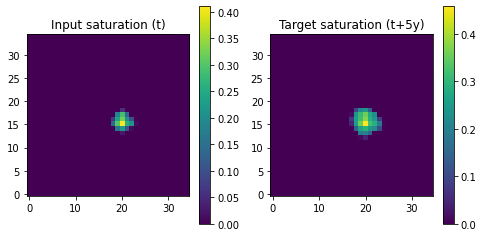

In [22]:
# pick arbitrary sample
X, Y = train_dataset[11]
s_in  = X[1].numpy()[:, :, 3]   # saturation input at mid z
s_out = Y[1].numpy()[:, :, 3]   # saturation target at mid z

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(s_in, origin='lower', cmap='viridis')
axs[0].set_title("Input saturation (t)")
im1 = axs[1].imshow(s_out, origin='lower', cmap='viridis')
axs[1].set_title("Target saturation (t+5y)")
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()

## Model

In [23]:
class CO2Transformer3D(nn.Module):
    """
    Patch-based 3D Transformer surrogate for CO2 storage.

    Input:  x  of shape (B, C_in, Nx, Ny, Nz)
    Output: y  of shape (B, 2,  Nx, Ny, Nz)  -> [pressure, saturation]
    """

    def __init__(
        self,
        in_ch: int = 4,
        out_ch: int = 2,
        vol_shape: tuple = (35, 35, 11),
        patch_size: tuple = (5, 5, 1),
        d_model: int = 256,
        nhead: int = 8,
        num_layers: int = 8,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.vol_shape = vol_shape
        self.patch_size = patch_size

        Nx, Ny, Nz = vol_shape
        px, py, pz = patch_size

        # Volume must be evenly split into patches
        assert Nx % px == 0 and Ny % py == 0 and Nz % pz == 0, \
            f"Volume {vol_shape} must be divisible by patch_size {patch_size}"

        # Grid size after patchification
        self.gx = Nx // px   # 35 / 5 = 7
        self.gy = Ny // py   # 35 / 5 = 7
        self.gz = Nz // pz   # 11 / 1 = 11
        self.num_tokens = self.gx * self.gy * self.gz    # 7 * 7 * 11 = 539
        self.patch_volume = px * py * pz                 # 5 * 5 * 1 = 25
        self.d_model = d_model

        # 1) Patch embedding: Conv3d with stride = patch size
        self.patch_embed = nn.Conv3d(
            in_ch,
            d_model,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
            bias=True,
        )

        # 2) Fixed sinusoidal positional encodings for each patch token
        #    We register as a buffer so it moves with .to(device)
        pos_embed = self._build_3d_sincos_pos_embed(
            gx=self.gx,
            gy=self.gy,
            gz=self.gz,
            d_model=d_model,
        )  # (1, num_tokens, d_model)
        self.register_buffer("pos_embed", pos_embed, persistent=False)

        # 3) Transformer encoder (operates on patch tokens)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, L, D)
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # 4) Head: map token embeddings back to per-voxel predictions
        self.head = nn.Linear(d_model, out_ch * self.patch_volume)

        self._reset_parameters()

    # --------- positional encoding builder ---------
    def _build_3d_sincos_pos_embed(self, gx, gy, gz, d_model):
        """
        Build 3D sinusoidal positional encodings.

        For voxel/patch coordinates (x, y, z):

        PE_{2i}(x,y,z)   = sin( (x + y + 2z) / 10000^{2i/d} )
        PE_{2i+1}(x,y,z) = cos( (x + y + 2z) / 10000^{2i/d} )

        where d = d_model, and z is weighted more heavily (factor 2).
        """
        # grid of patch indices
        xs = torch.arange(gx, dtype=torch.float32)
        ys = torch.arange(gy, dtype=torch.float32)
        zs = torch.arange(gz, dtype=torch.float32)

        # (gx, gy, gz, 3) with ij indexing to match Conv3d layout
        grid_x, grid_y, grid_z = torch.meshgrid(xs, ys, zs, indexing="ij")
        # scalar coordinate combining x,y,z (depth z weighted more)
        u = grid_x + grid_y + 2.0 * grid_z          # (gx, gy, gz)
        u = u.reshape(-1, 1)                        # (L, 1) where L = num_tokens

        dim_half = d_model // 2
        # shape (dim_half,)
        div_term = torch.pow(
            torch.tensor(10000.0, dtype=torch.float32),
            torch.arange(0, dim_half, dtype=torch.float32) * 2.0 / d_model,
        )  # 10000^{2i/d}

        # (L, dim_half)
        angles = u / div_term  # broadcast over dim_half

        pe = torch.zeros(self.num_tokens, d_model, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angles)   # even indices 2i
        pe[:, 1::2] = torch.cos(angles)   # odd indices 2i+1

        # add batch dimension -> (1, L, D)
        pe = pe.unsqueeze(0)
        return pe

    # --------- init weights (no longer touching pos_embed) ---------
    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.patch_embed.weight)
        if self.patch_embed.bias is not None:
            nn.init.zeros_(self.patch_embed.bias)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    # --------- forward ---------
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C_in, Nx, Ny, Nz)
        returns: (B, 2, Nx, Ny, Nz)
        """
        B, C, Nx, Ny, Nz = x.shape
        px, py, pz = self.patch_size

        # 1) Patchify & embed -> (B, d_model, gx, gy, gz)
        x = self.patch_embed(x)

        _, D, gx, gy, gz = x.shape
        assert gx == self.gx and gy == self.gy and gz == self.gz, \
            "Unexpected grid size after patch embedding"

        # 2) Flatten spatial dims -> (B, L, d_model)
        x = x.flatten(2).transpose(1, 2)  # (B, L, D)
        L = x.size(1)
        assert L == self.num_tokens, f"Token length mismatch: {L} vs {self.num_tokens}"

        # 3) Add positional encoding (broadcast over batch)
        x = x + self.pos_embed  # (1, L, D) + (B, L, D) → (B, L, D)

        # 4) Transformer encoder
        x = self.encoder(x)  # (B, L, D)

        # 5) Predict per-voxel values inside each patch
        x = self.head(x)  # (B, L, out_ch * patch_volume)

        # 6) Unpatchify back to 3D volume
        x = x.view(
            B,
            self.gx,
            self.gy,
            self.gz,
            self.out_ch,
            px,
            py,
            pz,
        )  # (B, gx, gy, gz, C, px, py, pz)

        x = x.permute(0, 4, 1, 5, 2, 6, 3, 7)  # (B, C, gx, px, gy, py, gz, pz)
        x = x.reshape(B, self.out_ch, Nx, Ny, Nz)

        # 7) Channel 0: pressure (linear), channel 1: saturation (sigmoid)
        p = x[:, 0:1, ...]
        s = x[:, 1:2, ...]
        s = torch.sigmoid(s)

        out = torch.cat([p, s], dim=1)  # (B, 2, Nx, Ny, Nz)
        return out

In [24]:
C_in = 4   # number of input channels
C_out = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the Transformer-based surrogate
torch.manual_seed(SEED)
model = CO2Transformer3D(
    in_ch=C_in,
    out_ch=C_out,
    vol_shape=(35, 35, 11),
    patch_size=(5, 5, 1),   # 7x7x11 tokens
    d_model= 256, # baseline is 128, we're trying various sizes
    nhead= 8,     # We experimented with various attention heads
    num_layers= 12,           # We experimented with various num of layers
    dim_feedforward= 1536,
    dropout=0.1,
).to(device)

In [25]:
#model.load_state_dict(torch.load('best_CO2'))

In [26]:
summary(model,input_size=(1,4, 35, 35, 11), device='cuda')

Layer (type:depth-idx)                        Output Shape              Param #
CO2Transformer3D                              [1, 2, 35, 35, 11]        --
├─Conv3d: 1-1                                 [1, 256, 7, 7, 11]        25,856
├─TransformerEncoder: 1-2                     [1, 539, 256]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-2      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-3      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-4      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-5      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-6      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-7      [1, 539, 256]             1,052,416
│    │    └─TransformerEncoderLayer: 3-8  

In [27]:
# ---------------------------
# Loss function
# ---------------------------
# def loss_fn(pred, target, lambda_s=1.0, plume_tau=0.002, plume_w=50):
#     """
#     pred, target: tensors of shape (B, 2, 35, 35, 11)
#     lambda_s: weighting factor for saturation term
#     """
#     # Split into pressure and saturation channels
#     P_pred, S_pred = pred[:, 0], pred[:, 1]
#     P_true, S_true = target[:, 0], target[:, 1]
    
#     # L1 loss for each field
#     loss_p = F.mse_loss(P_pred, P_true)
#     #loss_s = F.mse_loss(S_pred, S_true)
#     w = torch.ones_like(S_true)
#     w = torch.where(torch.abs(S_true - S_pred) > plume_tau, torch.full_like(w, plume_w), w)
#     loss_s = (w * (S_pred - S_true)**2).mean()
    
    
#     total_loss = loss_p + lambda_s * loss_s 
#     return total_loss, loss_p.item(), loss_s.item()

def loss_fn(pred, target, lambda_s=2.0, plume_tau=0.02, plume_w=50):
    """
    pred, target: tensors of shape (B, 2, 35, 35, 11)
    lambda_s: weighting factor for saturation term
    """
    # Split into pressure and saturation channels
    P_pred, S_pred = pred[:, 0], pred[:, 1]
    P_true, S_true = target[:, 0], target[:, 1]
    
    # L1 loss for each field
    loss_p = F.mse_loss(P_pred, P_true)
    #loss_s = F.mse_loss(S_pred, S_true)
    w = torch.ones_like(S_true)
    w = torch.where(S_true > plume_tau, torch.full_like(w, plume_w), w)
    loss_s = (w * (S_pred - S_true)**2).mean()
    
    
    total_loss = loss_p + lambda_s * loss_s 
    return total_loss, loss_p.item(), loss_s.item()


In [28]:
def r2_score_per_channel(y_pred, y_true, eps: float = 1e-8):
    """
    y_* : (B, 2, D, H, W)  -> [pressure, saturation]

    Returns:
        r2_p: mean R² for pressure over batch
        r2_s: mean R² for saturation over batch
    """
    assert y_pred.shape == y_true.shape
    B, C, D, H, W = y_pred.shape
    assert C == 2, "Expect 2 channels: pressure, saturation"

    p_pred, s_pred = y_pred[:, 0], y_pred[:, 1]   # (B, D, H, W)
    p_true, s_true = y_true[:, 0], y_true[:, 1]

    def _r2(yhat, y):
        # reshape to (B, N)
        yhat = yhat.reshape(B, -1)
        y = y.reshape(B, -1)

        # mean of true values per sample
        y_mean = y.mean(dim=1, keepdim=True)

        # SS_res and SS_tot
        ss_res = ((y - yhat)**2).sum(dim=1)
        ss_tot = ((y - y_mean)**2).sum(dim=1) + eps

        r2 = 1 - ss_res / ss_tot   # (B,)
        return r2.mean().item()

    r2_p = _r2(p_pred, p_true)
    r2_s = _r2(s_pred, s_true)
    return r2_p, r2_s

In [29]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

In [30]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=5,
                                                 verbose=True)

In [31]:
print("model param id:", id(list(model.parameters())[0]))
print("opt   param id:", id(optimizer.param_groups[0]['params'][0]))

model param id: 140009260160960
opt   param id: 140009260160960


In [32]:
# Track metrics across epochs
train_total_hist, val_total_hist = [], []
train_p_hist, train_s_hist = [], []
val_p_hist, val_s_hist = [], []
train_p_corr_hist, train_s_corr_hist = [], []
val_p_corr_hist, val_s_corr_hist = [], []

# ---------------------------
# Configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 200
lambda_s = 2.0      # weight for saturation term
log_interval = 4000   # print every N batches

# Move model to GPU/CPU
model = model.to(device)

# ---------------------------
# Training and validation loops
# ---------------------------
def train_one_epoch(model, dataloader, optimizer, lambda_s=2.0):
    model.train()
    running_loss, running_p, running_s = 0.0, 0.0, 0.0
    running_p_corr, running_s_corr = 0.0, 0.0

    for batch_idx, (X, Y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        X, Y = X.to(device), Y.to(device)

        # Forward
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        running_loss += loss.item()
        running_p += loss_p
        running_s += loss_s

        # Correlation (detach so it's not in the graph)
        p_corr, s_corr = r2_score_per_channel(pred.detach(), Y)
        running_p_corr += p_corr
        running_s_corr += s_corr

        if (batch_idx + 1) % log_interval == 0:
            print(f"  [Batch {batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item():.4f} | L_P: {loss_p:.4f} | "
                  f"L_S: {loss_s:.4f} | r_P: {p_corr:.3f} | r_S: {s_corr:.3f}")

    n = len(dataloader)
    return (running_loss / n,
            running_p / n,
            running_s / n,
            running_p_corr / n,
            running_s_corr / n)


@torch.no_grad()
def evaluate(model, dataloader, lambda_s=1.0):
    model.eval()
    total_loss, total_p, total_s = 0.0, 0.0, 0.0
    total_p_corr, total_s_corr = 0.0, 0.0

    for X, Y in tqdm(dataloader, desc="Validation", leave=False):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)

        total_loss += loss.item()
        total_p += loss_p
        total_s += loss_s

        p_corr, s_corr = r2_score_per_channel (pred, Y)
        total_p_corr += p_corr
        total_s_corr += s_corr

    n = len(dataloader)
    return (total_loss / n,
            total_p / n,
            total_s / n,
            total_p_corr / n,
            total_s_corr / n)


# ---------------------------
# Main training loop
# ---------------------------
best_val_loss = float('inf')

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    (train_loss, train_p, train_s,
     train_p_corr, train_s_corr) = train_one_epoch(model, train_loader, optimizer, lambda_s)

    torch.cuda.empty_cache()

    (val_loss, val_p, val_s,
     val_p_corr, val_s_corr) = evaluate(model, dev_loader, lambda_s)

    torch.cuda.empty_cache()

    print(f"  Train: L={train_loss:.6f} | L_P={train_p:.6f} | L_S={train_s:.6f} "
          f"| r_P={train_p_corr:.6f} | r_S={train_s_corr:.6f}")
    print(f"  Valid: L={val_loss:.6f} | L_P={val_p:.6f} | L_S={val_s:.6f} "
          f"| r_P={val_p_corr:.6f} | r_S={val_s_corr:.6f}")

    # Record history
    train_total_hist.append(train_loss)
    val_total_hist.append(val_loss)
    train_p_hist.append(train_p)
    train_s_hist.append(train_s)
    val_p_hist.append(val_p)
    val_s_hist.append(val_s)

    train_p_corr_hist.append(train_p_corr)
    train_s_corr_hist.append(train_s_corr)
    val_p_corr_hist.append(val_p_corr)
    val_s_corr_hist.append(val_s_corr)

    if 'scheduler' in locals():
        scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_CO2Tranformer.pt")
        print("Saved new best model")

end_time = time.time()
training_time = end_time - start_time
print("Training time: %.4f" %(training_time))
print("\nTraining complete. Best validation loss:", best_val_loss)



Epoch 1/200


  Train: L=0.732543 | L_P=0.611055 | L_S=0.060744 | r_P=0.375675 | r_S=-8.301839
  Valid: L=0.144398 | L_P=0.056728 | L_S=0.043835 | r_P=0.945927 | r_S=-5.465330
Saved new best model

Epoch 2/200


  Train: L=0.141606 | L_P=0.059212 | L_S=0.041197 | r_P=0.943492 | r_S=-4.756422
  Valid: L=0.121700 | L_P=0.055516 | L_S=0.033092 | r_P=0.946906 | r_S=-2.146939
Saved new best model

Epoch 3/200


  Train: L=0.094865 | L_P=0.043959 | L_S=0.025453 | r_P=0.958694 | r_S=-0.928551
  Valid: L=0.079406 | L_P=0.033965 | L_S=0.022720 | r_P=0.968284 | r_S=-0.494204
Saved new best model

Epoch 4/200


  Train: L=0.067765 | L_P=0.034927 | L_S=0.016419 | r_P=0.967375 | r_S=-0.056132
  Valid: L=0.044537 | L_P=0.025900 | L_S=0.009319 | r_P=0.975659 | r_S=0.440254
Saved new best model

Epoch 5/200


  Train: L=0.045247 | L_P=0.026713 | L_S=0.009267 | r_P=0.975194 | r_S=0.474474
  Valid: L=0.039508 | L_P=0.023708 | L_S=0.007900 | r_P=0.977677 | r_S=0.425089
Saved new best model

Epoch 6/200


  Train: L=0.039531 | L_P=0.023912 | L_S=0.007810 | r_P=0.977883 | r_S=0.532661
  Valid: L=0.033355 | L_P=0.019944 | L_S=0.006705 | r_P=0.981635 | r_S=0.525919
Saved new best model

Epoch 7/200


  Train: L=0.035836 | L_P=0.022067 | L_S=0.006885 | r_P=0.979655 | r_S=0.567227
  Valid: L=0.034556 | L_P=0.021187 | L_S=0.006685 | r_P=0.980163 | r_S=0.489557

Epoch 8/200


  Train: L=0.034271 | L_P=0.021359 | L_S=0.006456 | r_P=0.980327 | r_S=0.584121
  Valid: L=0.029641 | L_P=0.019184 | L_S=0.005229 | r_P=0.982131 | r_S=0.636801
Saved new best model

Epoch 9/200


  Train: L=0.031042 | L_P=0.019611 | L_S=0.005715 | r_P=0.982012 | r_S=0.617356
  Valid: L=0.027124 | L_P=0.017015 | L_S=0.005054 | r_P=0.984198 | r_S=0.641894
Saved new best model

Epoch 10/200


  Train: L=0.029263 | L_P=0.018698 | L_S=0.005283 | r_P=0.982865 | r_S=0.637905
  Valid: L=0.024806 | L_P=0.015973 | L_S=0.004417 | r_P=0.985148 | r_S=0.635227
Saved new best model

Epoch 11/200


  Train: L=0.027392 | L_P=0.017680 | L_S=0.004856 | r_P=0.983825 | r_S=0.657071
  Valid: L=0.023508 | L_P=0.014989 | L_S=0.004260 | r_P=0.986230 | r_S=0.637210
Saved new best model

Epoch 12/200


  Train: L=0.027974 | L_P=0.018201 | L_S=0.004887 | r_P=0.983299 | r_S=0.656581
  Valid: L=0.023291 | L_P=0.015150 | L_S=0.004071 | r_P=0.986035 | r_S=0.665091
Saved new best model

Epoch 13/200


  Train: L=0.025914 | L_P=0.016917 | L_S=0.004498 | r_P=0.984517 | r_S=0.678818
  Valid: L=0.022955 | L_P=0.015268 | L_S=0.003843 | r_P=0.985815 | r_S=0.750879
Saved new best model

Epoch 14/200


  Train: L=0.023767 | L_P=0.015728 | L_S=0.004019 | r_P=0.985643 | r_S=0.704971
  Valid: L=0.021921 | L_P=0.014919 | L_S=0.003501 | r_P=0.986417 | r_S=0.725135
Saved new best model

Epoch 15/200


  Train: L=0.022917 | L_P=0.015313 | L_S=0.003802 | r_P=0.986065 | r_S=0.714152
  Valid: L=0.022110 | L_P=0.015278 | L_S=0.003416 | r_P=0.985863 | r_S=0.685954

Epoch 16/200


  Train: L=0.021711 | L_P=0.014585 | L_S=0.003563 | r_P=0.986735 | r_S=0.729086
  Valid: L=0.020352 | L_P=0.013814 | L_S=0.003269 | r_P=0.987114 | r_S=0.729861
Saved new best model

Epoch 17/200


  Train: L=0.021077 | L_P=0.014261 | L_S=0.003408 | r_P=0.987037 | r_S=0.738104
  Valid: L=0.018805 | L_P=0.012901 | L_S=0.002952 | r_P=0.988160 | r_S=0.732984
Saved new best model

Epoch 18/200


  Train: L=0.020454 | L_P=0.013975 | L_S=0.003240 | r_P=0.987318 | r_S=0.747904
  Valid: L=0.018170 | L_P=0.012595 | L_S=0.002788 | r_P=0.988358 | r_S=0.756771
Saved new best model

Epoch 19/200


  Train: L=0.019293 | L_P=0.013256 | L_S=0.003019 | r_P=0.987982 | r_S=0.758053
  Valid: L=0.017546 | L_P=0.012278 | L_S=0.002634 | r_P=0.988706 | r_S=0.723898
Saved new best model

Epoch 20/200


  Train: L=0.019124 | L_P=0.013260 | L_S=0.002932 | r_P=0.987986 | r_S=0.759836
  Valid: L=0.017368 | L_P=0.012294 | L_S=0.002537 | r_P=0.988735 | r_S=0.765821
Saved new best model

Epoch 21/200


  Train: L=0.018330 | L_P=0.012785 | L_S=0.002772 | r_P=0.988426 | r_S=0.774468
  Valid: L=0.017462 | L_P=0.012573 | L_S=0.002445 | r_P=0.988344 | r_S=0.767747

Epoch 22/200


  Train: L=0.018322 | L_P=0.012848 | L_S=0.002737 | r_P=0.988373 | r_S=0.773607
  Valid: L=0.015601 | L_P=0.011113 | L_S=0.002244 | r_P=0.989785 | r_S=0.773702
Saved new best model

Epoch 23/200


  Train: L=0.017496 | L_P=0.012350 | L_S=0.002573 | r_P=0.988839 | r_S=0.781905
  Valid: L=0.015679 | L_P=0.011201 | L_S=0.002239 | r_P=0.989704 | r_S=0.772626

Epoch 24/200


  Train: L=0.019406 | L_P=0.013522 | L_S=0.002942 | r_P=0.987679 | r_S=0.761549
  Valid: L=0.016360 | L_P=0.011645 | L_S=0.002357 | r_P=0.989342 | r_S=0.765663

Epoch 25/200


  Train: L=0.016592 | L_P=0.011832 | L_S=0.002380 | r_P=0.989320 | r_S=0.793072
  Valid: L=0.015645 | L_P=0.011374 | L_S=0.002135 | r_P=0.989547 | r_S=0.787040

Epoch 26/200


  Train: L=0.016086 | L_P=0.011496 | L_S=0.002295 | r_P=0.989630 | r_S=0.797291
  Valid: L=0.014978 | L_P=0.010904 | L_S=0.002037 | r_P=0.989987 | r_S=0.795855
Saved new best model

Epoch 27/200


  Train: L=0.018830 | L_P=0.013448 | L_S=0.002691 | r_P=0.987760 | r_S=0.774866
  Valid: L=0.020368 | L_P=0.014029 | L_S=0.003169 | r_P=0.987080 | r_S=0.749297

Epoch 28/200


  Train: L=0.016775 | L_P=0.011900 | L_S=0.002438 | r_P=0.989263 | r_S=0.790015
  Valid: L=0.015256 | L_P=0.011254 | L_S=0.002001 | r_P=0.989706 | r_S=0.818499

Epoch 29/200


  Train: L=0.015271 | L_P=0.010999 | L_S=0.002136 | r_P=0.990097 | r_S=0.808188
  Valid: L=0.014823 | L_P=0.010819 | L_S=0.002002 | r_P=0.990113 | r_S=0.776225
Saved new best model

Epoch 30/200


  Train: L=0.015373 | L_P=0.011132 | L_S=0.002120 | r_P=0.989973 | r_S=0.809590
  Valid: L=0.014768 | L_P=0.010914 | L_S=0.001927 | r_P=0.989940 | r_S=0.814605
Saved new best model

Epoch 31/200


  Train: L=0.015487 | L_P=0.011281 | L_S=0.002103 | r_P=0.989837 | r_S=0.809279
  Valid: L=0.017158 | L_P=0.013024 | L_S=0.002067 | r_P=0.988049 | r_S=0.791221

Epoch 32/200


  Train: L=0.015269 | L_P=0.011117 | L_S=0.002076 | r_P=0.989993 | r_S=0.807450
  Valid: L=0.014843 | L_P=0.011141 | L_S=0.001851 | r_P=0.989746 | r_S=0.820385

Epoch 33/200


  Train: L=0.014812 | L_P=0.010840 | L_S=0.001986 | r_P=0.990243 | r_S=0.815030
  Valid: L=0.014367 | L_P=0.010663 | L_S=0.001852 | r_P=0.990177 | r_S=0.809239
Saved new best model

Epoch 34/200


  Train: L=0.016046 | L_P=0.011622 | L_S=0.002212 | r_P=0.989480 | r_S=0.805090
  Valid: L=0.015248 | L_P=0.011515 | L_S=0.001867 | r_P=0.989473 | r_S=0.784845

Epoch 35/200


  Train: L=0.014570 | L_P=0.010688 | L_S=0.001941 | r_P=0.990392 | r_S=0.817037
  Valid: L=0.014303 | L_P=0.010683 | L_S=0.001810 | r_P=0.990197 | r_S=0.796976
Saved new best model

Epoch 36/200


  Train: L=0.014121 | L_P=0.010430 | L_S=0.001846 | r_P=0.990627 | r_S=0.824260
  Valid: L=0.014066 | L_P=0.010456 | L_S=0.001805 | r_P=0.990389 | r_S=0.821091
Saved new best model

Epoch 37/200


  Train: L=0.014443 | L_P=0.010666 | L_S=0.001888 | r_P=0.990415 | r_S=0.817866
  Valid: L=0.014260 | L_P=0.010712 | L_S=0.001774 | r_P=0.990180 | r_S=0.827440

Epoch 38/200


  Train: L=0.014196 | L_P=0.010499 | L_S=0.001848 | r_P=0.990561 | r_S=0.821440
  Valid: L=0.014601 | L_P=0.011074 | L_S=0.001763 | r_P=0.989829 | r_S=0.822292

Epoch 39/200


  Train: L=0.014088 | L_P=0.010469 | L_S=0.001810 | r_P=0.990594 | r_S=0.823729
  Valid: L=0.013504 | L_P=0.010265 | L_S=0.001620 | r_P=0.990588 | r_S=0.822524
Saved new best model

Epoch 40/200


  Train: L=0.014045 | L_P=0.010470 | L_S=0.001788 | r_P=0.990586 | r_S=0.825704
  Valid: L=0.014155 | L_P=0.010790 | L_S=0.001683 | r_P=0.990044 | r_S=0.819414

Epoch 41/200


  Train: L=0.013634 | L_P=0.010189 | L_S=0.001722 | r_P=0.990847 | r_S=0.829006
  Valid: L=0.014440 | L_P=0.011132 | L_S=0.001654 | r_P=0.989706 | r_S=0.813609

Epoch 42/200


  Train: L=0.013556 | L_P=0.010151 | L_S=0.001702 | r_P=0.990879 | r_S=0.828401
  Valid: L=0.014207 | L_P=0.010746 | L_S=0.001730 | r_P=0.990123 | r_S=0.810175

Epoch 43/200


  Train: L=0.013811 | L_P=0.010337 | L_S=0.001737 | r_P=0.990722 | r_S=0.825201
  Valid: L=0.014107 | L_P=0.010860 | L_S=0.001623 | r_P=0.989984 | r_S=0.829747

Epoch 44/200


  Train: L=0.013170 | L_P=0.009907 | L_S=0.001631 | r_P=0.991114 | r_S=0.834926
  Valid: L=0.013593 | L_P=0.010280 | L_S=0.001656 | r_P=0.990591 | r_S=0.809386

Epoch 45/200


  Train: L=0.012764 | L_P=0.009639 | L_S=0.001563 | r_P=0.991359 | r_S=0.838740
  Valid: L=0.013284 | L_P=0.010134 | L_S=0.001575 | r_P=0.990749 | r_S=0.825923
Saved new best model

Epoch 46/200


  Train: L=0.013930 | L_P=0.010475 | L_S=0.001728 | r_P=0.990584 | r_S=0.825777
  Valid: L=0.013085 | L_P=0.010025 | L_S=0.001530 | r_P=0.990789 | r_S=0.829332
Saved new best model

Epoch 47/200


  Train: L=0.012729 | L_P=0.009649 | L_S=0.001540 | r_P=0.991354 | r_S=0.838955
  Valid: L=0.014704 | L_P=0.011662 | L_S=0.001521 | r_P=0.989339 | r_S=0.821793

Epoch 48/200


  Train: L=0.012218 | L_P=0.009310 | L_S=0.001454 | r_P=0.991666 | r_S=0.848542
  Valid: L=0.012797 | L_P=0.009909 | L_S=0.001444 | r_P=0.990904 | r_S=0.850394
Saved new best model

Epoch 49/200


  Train: L=0.012789 | L_P=0.009731 | L_S=0.001529 | r_P=0.991269 | r_S=0.840808
  Valid: L=0.012754 | L_P=0.009817 | L_S=0.001468 | r_P=0.991018 | r_S=0.835164
Saved new best model

Epoch 50/200


  Train: L=0.012705 | L_P=0.009663 | L_S=0.001521 | r_P=0.991338 | r_S=0.840725
  Valid: L=0.013368 | L_P=0.010320 | L_S=0.001524 | r_P=0.990547 | r_S=0.837725

Epoch 51/200


  Train: L=0.012256 | L_P=0.009380 | L_S=0.001438 | r_P=0.991601 | r_S=0.847508
  Valid: L=0.013092 | L_P=0.010182 | L_S=0.001455 | r_P=0.990673 | r_S=0.813679

Epoch 52/200


  Train: L=0.012316 | L_P=0.009434 | L_S=0.001441 | r_P=0.991550 | r_S=0.844412
  Valid: L=0.012890 | L_P=0.009854 | L_S=0.001518 | r_P=0.991040 | r_S=0.830513

Epoch 53/200


  Train: L=0.013010 | L_P=0.009930 | L_S=0.001540 | r_P=0.991100 | r_S=0.839619
  Valid: L=0.013782 | L_P=0.010565 | L_S=0.001608 | r_P=0.990307 | r_S=0.824525

Epoch 54/200


  Train: L=0.012722 | L_P=0.009765 | L_S=0.001479 | r_P=0.991261 | r_S=0.841109
  Valid: L=0.013017 | L_P=0.010187 | L_S=0.001415 | r_P=0.990674 | r_S=0.828443

Epoch 55/200


  Train: L=0.012084 | L_P=0.009320 | L_S=0.001382 | r_P=0.991666 | r_S=0.850679
  Valid: L=0.012573 | L_P=0.009767 | L_S=0.001403 | r_P=0.991047 | r_S=0.843638
Saved new best model

Epoch 56/200


  Train: L=0.011555 | L_P=0.008971 | L_S=0.001292 | r_P=0.991980 | r_S=0.857176
  Valid: L=0.012065 | L_P=0.009369 | L_S=0.001348 | r_P=0.991460 | r_S=0.849291
Saved new best model

Epoch 57/200


  Train: L=0.012066 | L_P=0.009353 | L_S=0.001356 | r_P=0.991625 | r_S=0.853919
  Valid: L=0.013380 | L_P=0.010484 | L_S=0.001448 | r_P=0.990363 | r_S=0.837269

Epoch 58/200


  Train: L=0.012219 | L_P=0.009460 | L_S=0.001380 | r_P=0.991533 | r_S=0.850473
  Valid: L=0.012401 | L_P=0.009741 | L_S=0.001330 | r_P=0.991095 | r_S=0.837008

Epoch 59/200


  Train: L=0.011534 | L_P=0.009000 | L_S=0.001267 | r_P=0.991952 | r_S=0.858262
  Valid: L=0.012086 | L_P=0.009442 | L_S=0.001322 | r_P=0.991381 | r_S=0.841643

Epoch 60/200


  Train: L=0.011596 | L_P=0.009060 | L_S=0.001268 | r_P=0.991896 | r_S=0.859287
  Valid: L=0.012289 | L_P=0.009629 | L_S=0.001330 | r_P=0.991172 | r_S=0.842591

Epoch 61/200


  Train: L=0.011651 | L_P=0.009111 | L_S=0.001270 | r_P=0.991852 | r_S=0.855670
  Valid: L=0.012376 | L_P=0.009725 | L_S=0.001325 | r_P=0.991080 | r_S=0.852406

Epoch 62/200


  Train: L=0.012118 | L_P=0.009417 | L_S=0.001350 | r_P=0.991534 | r_S=0.856969
  Valid: L=0.012943 | L_P=0.009947 | L_S=0.001498 | r_P=0.990927 | r_S=0.824639
Epoch 00062: reducing learning rate of group 0 to 1.5000e-04.

Epoch 63/200


  Train: L=0.010779 | L_P=0.008520 | L_S=0.001130 | r_P=0.992403 | r_S=0.868321
  Valid: L=0.011714 | L_P=0.009316 | L_S=0.001199 | r_P=0.991478 | r_S=0.856196
Saved new best model

Epoch 64/200


  Train: L=0.010193 | L_P=0.008199 | L_S=0.000997 | r_P=0.992697 | r_S=0.877338
  Valid: L=0.011576 | L_P=0.009244 | L_S=0.001166 | r_P=0.991550 | r_S=0.862621
Saved new best model

Epoch 65/200


  Train: L=0.009974 | L_P=0.008080 | L_S=0.000947 | r_P=0.992806 | r_S=0.881253
  Valid: L=0.011390 | L_P=0.009094 | L_S=0.001148 | r_P=0.991683 | r_S=0.865805
Saved new best model

Epoch 66/200


  Train: L=0.009901 | L_P=0.008063 | L_S=0.000919 | r_P=0.992821 | r_S=0.883496
  Valid: L=0.011465 | L_P=0.009153 | L_S=0.001156 | r_P=0.991641 | r_S=0.866845

Epoch 67/200


  Train: L=0.009940 | L_P=0.008117 | L_S=0.000912 | r_P=0.992771 | r_S=0.883677
  Valid: L=0.011476 | L_P=0.009168 | L_S=0.001154 | r_P=0.991608 | r_S=0.874097

Epoch 68/200


  Train: L=0.009914 | L_P=0.008126 | L_S=0.000894 | r_P=0.992762 | r_S=0.884937
  Valid: L=0.011360 | L_P=0.009050 | L_S=0.001155 | r_P=0.991722 | r_S=0.871795
Saved new best model

Epoch 69/200


  Train: L=0.009866 | L_P=0.008107 | L_S=0.000880 | r_P=0.992780 | r_S=0.885480
  Valid: L=0.011546 | L_P=0.009254 | L_S=0.001146 | r_P=0.991514 | r_S=0.861696

Epoch 70/200


  Train: L=0.009895 | L_P=0.008151 | L_S=0.000872 | r_P=0.992740 | r_S=0.885830
  Valid: L=0.011554 | L_P=0.009221 | L_S=0.001166 | r_P=0.991558 | r_S=0.862054

Epoch 71/200


  Train: L=0.009933 | L_P=0.008193 | L_S=0.000870 | r_P=0.992704 | r_S=0.885207
  Valid: L=0.011614 | L_P=0.009336 | L_S=0.001139 | r_P=0.991433 | r_S=0.872783

Epoch 72/200


  Train: L=0.009787 | L_P=0.008108 | L_S=0.000840 | r_P=0.992782 | r_S=0.886448
  Valid: L=0.011320 | L_P=0.009081 | L_S=0.001120 | r_P=0.991685 | r_S=0.871367
Saved new best model

Epoch 73/200


  Train: L=0.009630 | L_P=0.008017 | L_S=0.000806 | r_P=0.992864 | r_S=0.889594
  Valid: L=0.011288 | L_P=0.009054 | L_S=0.001117 | r_P=0.991721 | r_S=0.871140
Saved new best model

Epoch 74/200


  Train: L=0.009576 | L_P=0.007993 | L_S=0.000792 | r_P=0.992886 | r_S=0.890589
  Valid: L=0.011405 | L_P=0.009121 | L_S=0.001142 | r_P=0.991663 | r_S=0.870492

Epoch 75/200


  Train: L=0.009585 | L_P=0.008012 | L_S=0.000787 | r_P=0.992869 | r_S=0.890868
  Valid: L=0.011338 | L_P=0.009115 | L_S=0.001111 | r_P=0.991657 | r_S=0.871221

Epoch 76/200


  Train: L=0.009563 | L_P=0.008008 | L_S=0.000777 | r_P=0.992871 | r_S=0.891352
  Valid: L=0.011224 | L_P=0.008977 | L_S=0.001123 | r_P=0.991804 | r_S=0.874372
Saved new best model

Epoch 77/200


  Train: L=0.009563 | L_P=0.008022 | L_S=0.000770 | r_P=0.992859 | r_S=0.891629
  Valid: L=0.011284 | L_P=0.009047 | L_S=0.001118 | r_P=0.991732 | r_S=0.872194

Epoch 78/200


  Train: L=0.009629 | L_P=0.008074 | L_S=0.000778 | r_P=0.992811 | r_S=0.889670
  Valid: L=0.011292 | L_P=0.009070 | L_S=0.001111 | r_P=0.991704 | r_S=0.873036

Epoch 79/200


  Train: L=0.009531 | L_P=0.008027 | L_S=0.000752 | r_P=0.992856 | r_S=0.891826
  Valid: L=0.011135 | L_P=0.008901 | L_S=0.001117 | r_P=0.991868 | r_S=0.873001
Saved new best model

Epoch 80/200


  Train: L=0.009468 | L_P=0.007989 | L_S=0.000739 | r_P=0.992890 | r_S=0.892638
  Valid: L=0.011145 | L_P=0.008968 | L_S=0.001089 | r_P=0.991816 | r_S=0.879568

Epoch 81/200


  Train: L=0.009416 | L_P=0.007968 | L_S=0.000724 | r_P=0.992910 | r_S=0.893775
  Valid: L=0.011212 | L_P=0.009023 | L_S=0.001095 | r_P=0.991771 | r_S=0.868484

Epoch 82/200


  Train: L=0.009551 | L_P=0.008059 | L_S=0.000746 | r_P=0.992827 | r_S=0.889836
  Valid: L=0.011153 | L_P=0.008940 | L_S=0.001106 | r_P=0.991830 | r_S=0.874070

Epoch 83/200


  Train: L=0.009387 | L_P=0.007960 | L_S=0.000713 | r_P=0.992917 | r_S=0.893413
  Valid: L=0.011193 | L_P=0.008998 | L_S=0.001098 | r_P=0.991762 | r_S=0.876250

Epoch 84/200


  Train: L=0.009297 | L_P=0.007908 | L_S=0.000694 | r_P=0.992965 | r_S=0.895290
  Valid: L=0.011179 | L_P=0.009032 | L_S=0.001073 | r_P=0.991749 | r_S=0.871608

Epoch 85/200


  Train: L=0.009412 | L_P=0.007995 | L_S=0.000708 | r_P=0.992885 | r_S=0.894081
  Valid: L=0.011187 | L_P=0.009030 | L_S=0.001079 | r_P=0.991728 | r_S=0.880150
Epoch 00085: reducing learning rate of group 0 to 7.5000e-05.

Epoch 86/200


  Train: L=0.009084 | L_P=0.007815 | L_S=0.000634 | r_P=0.993053 | r_S=0.897621
  Valid: L=0.010866 | L_P=0.008787 | L_S=0.001039 | r_P=0.991973 | r_S=0.880847
Saved new best model

Epoch 87/200


  Train: L=0.008952 | L_P=0.007739 | L_S=0.000606 | r_P=0.993122 | r_S=0.899849
  Valid: L=0.010927 | L_P=0.008844 | L_S=0.001042 | r_P=0.991923 | r_S=0.873922

Epoch 88/200


  Train: L=0.008916 | L_P=0.007722 | L_S=0.000597 | r_P=0.993138 | r_S=0.900191
  Valid: L=0.010974 | L_P=0.008895 | L_S=0.001039 | r_P=0.991862 | r_S=0.882299

Epoch 89/200


  Train: L=0.008895 | L_P=0.007715 | L_S=0.000590 | r_P=0.993144 | r_S=0.900412
  Valid: L=0.010873 | L_P=0.008804 | L_S=0.001035 | r_P=0.991964 | r_S=0.880029

Epoch 90/200


  Train: L=0.008897 | L_P=0.007723 | L_S=0.000587 | r_P=0.993137 | r_S=0.900775
  Valid: L=0.010980 | L_P=0.008906 | L_S=0.001037 | r_P=0.991849 | r_S=0.880638

Epoch 91/200


  Train: L=0.008890 | L_P=0.007728 | L_S=0.000581 | r_P=0.993133 | r_S=0.901054
  Valid: L=0.010873 | L_P=0.008826 | L_S=0.001023 | r_P=0.991935 | r_S=0.881810

Epoch 92/200


  Train: L=0.008874 | L_P=0.007722 | L_S=0.000576 | r_P=0.993138 | r_S=0.901567
  Valid: L=0.010952 | L_P=0.008893 | L_S=0.001029 | r_P=0.991872 | r_S=0.884284
Epoch 00092: reducing learning rate of group 0 to 3.7500e-05.

Epoch 93/200


  Train: L=0.008774 | L_P=0.007678 | L_S=0.000548 | r_P=0.993179 | r_S=0.902238
  Valid: L=0.010823 | L_P=0.008796 | L_S=0.001013 | r_P=0.991967 | r_S=0.882371
Saved new best model

Epoch 94/200


  Train: L=0.008737 | L_P=0.007660 | L_S=0.000538 | r_P=0.993197 | r_S=0.902907
  Valid: L=0.010803 | L_P=0.008785 | L_S=0.001009 | r_P=0.991977 | r_S=0.884532
Saved new best model

Epoch 95/200


  Train: L=0.008716 | L_P=0.007651 | L_S=0.000532 | r_P=0.993205 | r_S=0.903051
  Valid: L=0.010813 | L_P=0.008785 | L_S=0.001014 | r_P=0.991981 | r_S=0.881820

Epoch 96/200


  Train: L=0.008711 | L_P=0.007651 | L_S=0.000530 | r_P=0.993204 | r_S=0.903452
  Valid: L=0.010774 | L_P=0.008765 | L_S=0.001005 | r_P=0.991997 | r_S=0.882996
Saved new best model

Epoch 97/200


  Train: L=0.008700 | L_P=0.007647 | L_S=0.000527 | r_P=0.993208 | r_S=0.903518
  Valid: L=0.010860 | L_P=0.008831 | L_S=0.001014 | r_P=0.991935 | r_S=0.884049

Epoch 98/200


  Train: L=0.008693 | L_P=0.007646 | L_S=0.000523 | r_P=0.993209 | r_S=0.903675
  Valid: L=0.010809 | L_P=0.008788 | L_S=0.001011 | r_P=0.991971 | r_S=0.883822

Epoch 99/200


  Train: L=0.008680 | L_P=0.007640 | L_S=0.000520 | r_P=0.993214 | r_S=0.903812
  Valid: L=0.010840 | L_P=0.008813 | L_S=0.001014 | r_P=0.991951 | r_S=0.884725

Epoch 100/200


  Train: L=0.008674 | L_P=0.007642 | L_S=0.000516 | r_P=0.993213 | r_S=0.904022
  Valid: L=0.010834 | L_P=0.008834 | L_S=0.001000 | r_P=0.991931 | r_S=0.880977

Epoch 101/200


  Train: L=0.008667 | L_P=0.007639 | L_S=0.000514 | r_P=0.993215 | r_S=0.903892
  Valid: L=0.010834 | L_P=0.008824 | L_S=0.001005 | r_P=0.991944 | r_S=0.880793

Epoch 102/200


  Train: L=0.008659 | L_P=0.007637 | L_S=0.000511 | r_P=0.993217 | r_S=0.904245
  Valid: L=0.010815 | L_P=0.008808 | L_S=0.001003 | r_P=0.991956 | r_S=0.885073
Epoch 00102: reducing learning rate of group 0 to 1.8750e-05.

Epoch 103/200


  Train: L=0.008623 | L_P=0.007625 | L_S=0.000499 | r_P=0.993229 | r_S=0.904511
  Valid: L=0.010775 | L_P=0.008782 | L_S=0.000997 | r_P=0.991983 | r_S=0.885701

Epoch 104/200


  Train: L=0.008606 | L_P=0.007616 | L_S=0.000495 | r_P=0.993237 | r_S=0.904807
  Valid: L=0.010772 | L_P=0.008785 | L_S=0.000994 | r_P=0.991976 | r_S=0.885016
Saved new best model

Epoch 105/200


  Train: L=0.008606 | L_P=0.007620 | L_S=0.000493 | r_P=0.993234 | r_S=0.904784
  Valid: L=0.010764 | L_P=0.008784 | L_S=0.000990 | r_P=0.991978 | r_S=0.884394
Saved new best model

Epoch 106/200


  Train: L=0.008597 | L_P=0.007615 | L_S=0.000491 | r_P=0.993238 | r_S=0.905067
  Valid: L=0.010788 | L_P=0.008799 | L_S=0.000995 | r_P=0.991963 | r_S=0.884318

Epoch 107/200


  Train: L=0.008590 | L_P=0.007611 | L_S=0.000489 | r_P=0.993242 | r_S=0.905041
  Valid: L=0.010762 | L_P=0.008774 | L_S=0.000994 | r_P=0.991987 | r_S=0.884913
Saved new best model

Epoch 108/200


  Train: L=0.008582 | L_P=0.007609 | L_S=0.000487 | r_P=0.993244 | r_S=0.905380
  Valid: L=0.010782 | L_P=0.008792 | L_S=0.000995 | r_P=0.991967 | r_S=0.884404

Epoch 109/200


  Train: L=0.008582 | L_P=0.007610 | L_S=0.000486 | r_P=0.993243 | r_S=0.905082
  Valid: L=0.010781 | L_P=0.008784 | L_S=0.000998 | r_P=0.991977 | r_S=0.883433

Epoch 110/200


  Train: L=0.008575 | L_P=0.007607 | L_S=0.000484 | r_P=0.993245 | r_S=0.905381
  Valid: L=0.010766 | L_P=0.008781 | L_S=0.000993 | r_P=0.991979 | r_S=0.884053

Epoch 111/200


  Train: L=0.008574 | L_P=0.007609 | L_S=0.000483 | r_P=0.993244 | r_S=0.905129
  Valid: L=0.010782 | L_P=0.008785 | L_S=0.000999 | r_P=0.991975 | r_S=0.884657

Epoch 112/200


  Train: L=0.008566 | L_P=0.007605 | L_S=0.000480 | r_P=0.993247 | r_S=0.905248
  Valid: L=0.010793 | L_P=0.008800 | L_S=0.000997 | r_P=0.991962 | r_S=0.882597

Epoch 113/200


  Train: L=0.008565 | L_P=0.007606 | L_S=0.000479 | r_P=0.993246 | r_S=0.905395
  Valid: L=0.010752 | L_P=0.008767 | L_S=0.000993 | r_P=0.991995 | r_S=0.884771
Saved new best model

Epoch 114/200


  Train: L=0.008562 | L_P=0.007606 | L_S=0.000478 | r_P=0.993247 | r_S=0.905781
  Valid: L=0.010742 | L_P=0.008765 | L_S=0.000989 | r_P=0.991996 | r_S=0.884525
Saved new best model

Epoch 115/200


  Train: L=0.008558 | L_P=0.007603 | L_S=0.000478 | r_P=0.993249 | r_S=0.905624
  Valid: L=0.010760 | L_P=0.008780 | L_S=0.000990 | r_P=0.991978 | r_S=0.884828

Epoch 116/200


  Train: L=0.008553 | L_P=0.007603 | L_S=0.000475 | r_P=0.993249 | r_S=0.905736
  Valid: L=0.010770 | L_P=0.008780 | L_S=0.000995 | r_P=0.991980 | r_S=0.885785

Epoch 117/200


  Train: L=0.008548 | L_P=0.007600 | L_S=0.000474 | r_P=0.993252 | r_S=0.905603
  Valid: L=0.010772 | L_P=0.008781 | L_S=0.000996 | r_P=0.991982 | r_S=0.885920

Epoch 118/200


  Train: L=0.008544 | L_P=0.007599 | L_S=0.000473 | r_P=0.993253 | r_S=0.905976
  Valid: L=0.010781 | L_P=0.008800 | L_S=0.000991 | r_P=0.991960 | r_S=0.885381

Epoch 119/200


  Train: L=0.008543 | L_P=0.007601 | L_S=0.000471 | r_P=0.993251 | r_S=0.905866
  Valid: L=0.010753 | L_P=0.008763 | L_S=0.000995 | r_P=0.991999 | r_S=0.886531

Epoch 120/200


  Train: L=0.008540 | L_P=0.007601 | L_S=0.000469 | r_P=0.993251 | r_S=0.906088
  Valid: L=0.010759 | L_P=0.008777 | L_S=0.000991 | r_P=0.991983 | r_S=0.883953
Epoch 00120: reducing learning rate of group 0 to 9.3750e-06.

Epoch 121/200


  Train: L=0.008524 | L_P=0.007594 | L_S=0.000465 | r_P=0.993258 | r_S=0.906215
  Valid: L=0.010744 | L_P=0.008770 | L_S=0.000987 | r_P=0.991992 | r_S=0.885496

Epoch 122/200


  Train: L=0.008515 | L_P=0.007590 | L_S=0.000462 | r_P=0.993261 | r_S=0.906106
  Valid: L=0.010724 | L_P=0.008752 | L_S=0.000986 | r_P=0.992008 | r_S=0.884770
Saved new best model

Epoch 123/200


  Train: L=0.008514 | L_P=0.007592 | L_S=0.000461 | r_P=0.993260 | r_S=0.906165
  Valid: L=0.010737 | L_P=0.008759 | L_S=0.000989 | r_P=0.992002 | r_S=0.884474

Epoch 124/200


  Train: L=0.008512 | L_P=0.007589 | L_S=0.000462 | r_P=0.993262 | r_S=0.906313
  Valid: L=0.010739 | L_P=0.008767 | L_S=0.000986 | r_P=0.991994 | r_S=0.885590

Epoch 125/200


  Train: L=0.008512 | L_P=0.007591 | L_S=0.000461 | r_P=0.993260 | r_S=0.906252
  Valid: L=0.010746 | L_P=0.008773 | L_S=0.000987 | r_P=0.991988 | r_S=0.884264

Epoch 126/200


  Train: L=0.008506 | L_P=0.007589 | L_S=0.000459 | r_P=0.993263 | r_S=0.906414
  Valid: L=0.010727 | L_P=0.008759 | L_S=0.000984 | r_P=0.992002 | r_S=0.885617

Epoch 127/200


  Train: L=0.008508 | L_P=0.007590 | L_S=0.000459 | r_P=0.993262 | r_S=0.906236
  Valid: L=0.010748 | L_P=0.008773 | L_S=0.000987 | r_P=0.991986 | r_S=0.886126

Epoch 128/200


  Train: L=0.008503 | L_P=0.007587 | L_S=0.000458 | r_P=0.993264 | r_S=0.906596
  Valid: L=0.010742 | L_P=0.008766 | L_S=0.000988 | r_P=0.991995 | r_S=0.886448
Epoch 00128: reducing learning rate of group 0 to 4.6875e-06.

Epoch 129/200


  Train: L=0.008496 | L_P=0.007584 | L_S=0.000456 | r_P=0.993267 | r_S=0.906445
  Valid: L=0.010744 | L_P=0.008777 | L_S=0.000983 | r_P=0.991985 | r_S=0.886091

Epoch 130/200


  Train: L=0.008492 | L_P=0.007583 | L_S=0.000455 | r_P=0.993268 | r_S=0.906501
  Valid: L=0.010740 | L_P=0.008778 | L_S=0.000981 | r_P=0.991983 | r_S=0.885153

Epoch 131/200


  Train: L=0.008490 | L_P=0.007582 | L_S=0.000454 | r_P=0.993269 | r_S=0.906468
  Valid: L=0.010740 | L_P=0.008777 | L_S=0.000981 | r_P=0.991984 | r_S=0.886173

Epoch 132/200


  Train: L=0.008492 | L_P=0.007585 | L_S=0.000453 | r_P=0.993266 | r_S=0.906555
  Valid: L=0.010749 | L_P=0.008782 | L_S=0.000984 | r_P=0.991979 | r_S=0.885760

Epoch 133/200


  Train: L=0.008490 | L_P=0.007584 | L_S=0.000453 | r_P=0.993267 | r_S=0.906609
  Valid: L=0.010743 | L_P=0.008773 | L_S=0.000985 | r_P=0.991989 | r_S=0.885568

Epoch 134/200


  Train: L=0.008489 | L_P=0.007584 | L_S=0.000452 | r_P=0.993267 | r_S=0.906664
  Valid: L=0.010733 | L_P=0.008767 | L_S=0.000983 | r_P=0.991996 | r_S=0.885455
Epoch 00134: reducing learning rate of group 0 to 2.3437e-06.

Epoch 135/200


  Train: L=0.008483 | L_P=0.007580 | L_S=0.000452 | r_P=0.993271 | r_S=0.906430
  Valid: L=0.010736 | L_P=0.008772 | L_S=0.000982 | r_P=0.991991 | r_S=0.885507

Epoch 136/200


  Train: L=0.008483 | L_P=0.007583 | L_S=0.000450 | r_P=0.993268 | r_S=0.906696
  Valid: L=0.010734 | L_P=0.008769 | L_S=0.000983 | r_P=0.991993 | r_S=0.886113

Epoch 137/200


  Train: L=0.008483 | L_P=0.007581 | L_S=0.000451 | r_P=0.993270 | r_S=0.906519
  Valid: L=0.010732 | L_P=0.008770 | L_S=0.000981 | r_P=0.991992 | r_S=0.885827

Epoch 138/200


  Train: L=0.008483 | L_P=0.007583 | L_S=0.000450 | r_P=0.993268 | r_S=0.906662
  Valid: L=0.010729 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885861

Epoch 139/200


  Train: L=0.008480 | L_P=0.007580 | L_S=0.000450 | r_P=0.993271 | r_S=0.906458
  Valid: L=0.010734 | L_P=0.008771 | L_S=0.000982 | r_P=0.991990 | r_S=0.885428

Epoch 140/200


  Train: L=0.008481 | L_P=0.007581 | L_S=0.000450 | r_P=0.993270 | r_S=0.906581
  Valid: L=0.010737 | L_P=0.008773 | L_S=0.000982 | r_P=0.991989 | r_S=0.886157
Epoch 00140: reducing learning rate of group 0 to 1.1719e-06.

Epoch 141/200


  Train: L=0.008478 | L_P=0.007579 | L_S=0.000449 | r_P=0.993272 | r_S=0.906777
  Valid: L=0.010735 | L_P=0.008771 | L_S=0.000982 | r_P=0.991991 | r_S=0.885901

Epoch 142/200


  Train: L=0.008480 | L_P=0.007582 | L_S=0.000449 | r_P=0.993270 | r_S=0.906744
  Valid: L=0.010731 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885945

Epoch 143/200


  Train: L=0.008477 | L_P=0.007578 | L_S=0.000449 | r_P=0.993272 | r_S=0.906620
  Valid: L=0.010737 | L_P=0.008772 | L_S=0.000982 | r_P=0.991990 | r_S=0.886055

Epoch 144/200


  Train: L=0.008479 | L_P=0.007582 | L_S=0.000448 | r_P=0.993269 | r_S=0.906762
  Valid: L=0.010735 | L_P=0.008772 | L_S=0.000982 | r_P=0.991989 | r_S=0.885645

Epoch 145/200


  Train: L=0.008474 | L_P=0.007577 | L_S=0.000448 | r_P=0.993274 | r_S=0.906674
  Valid: L=0.010737 | L_P=0.008774 | L_S=0.000981 | r_P=0.991988 | r_S=0.885483

Epoch 146/200


  Train: L=0.008474 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906754
  Valid: L=0.010735 | L_P=0.008771 | L_S=0.000982 | r_P=0.991991 | r_S=0.886353
Epoch 00146: reducing learning rate of group 0 to 5.8594e-07.

Epoch 147/200


  Train: L=0.008475 | L_P=0.007578 | L_S=0.000448 | r_P=0.993272 | r_S=0.906890
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885930

Epoch 148/200


  Train: L=0.008475 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906833
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991993 | r_S=0.886036

Epoch 149/200


  Train: L=0.008474 | L_P=0.007578 | L_S=0.000448 | r_P=0.993272 | r_S=0.906853
  Valid: L=0.010731 | L_P=0.008768 | L_S=0.000982 | r_P=0.991994 | r_S=0.885832

Epoch 150/200


  Train: L=0.008475 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906697
  Valid: L=0.010731 | L_P=0.008769 | L_S=0.000981 | r_P=0.991993 | r_S=0.885914

Epoch 151/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906707
  Valid: L=0.010732 | L_P=0.008770 | L_S=0.000981 | r_P=0.991991 | r_S=0.885900

Epoch 152/200


  Train: L=0.008476 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906642
  Valid: L=0.010728 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885985
Epoch 00152: reducing learning rate of group 0 to 2.9297e-07.

Epoch 153/200


  Train: L=0.008474 | L_P=0.007577 | L_S=0.000448 | r_P=0.993273 | r_S=0.906765
  Valid: L=0.010731 | L_P=0.008769 | L_S=0.000981 | r_P=0.991992 | r_S=0.885909

Epoch 156/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906775
  Valid: L=0.010731 | L_P=0.008769 | L_S=0.000981 | r_P=0.991993 | r_S=0.885856

Epoch 157/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906705
  Valid: L=0.010731 | L_P=0.008769 | L_S=0.000981 | r_P=0.991992 | r_S=0.885818

Epoch 158/200


  Train: L=0.008472 | L_P=0.007578 | L_S=0.000447 | r_P=0.993273 | r_S=0.906644
  Valid: L=0.010731 | L_P=0.008769 | L_S=0.000981 | r_P=0.991992 | r_S=0.886014
Epoch 00158: reducing learning rate of group 0 to 1.4648e-07.

Epoch 159/200


  Train: L=0.008470 | L_P=0.007576 | L_S=0.000447 | r_P=0.993275 | r_S=0.906837
  Valid: L=0.010731 | L_P=0.008768 | L_S=0.000981 | r_P=0.991993 | r_S=0.885904

Epoch 160/200


  Train: L=0.008474 | L_P=0.007580 | L_S=0.000447 | r_P=0.993271 | r_S=0.906898
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991993 | r_S=0.885900

Epoch 161/200


  Train: L=0.008473 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906893
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885909

Epoch 162/200


  Train: L=0.008473 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906668
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885956

Epoch 163/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000447 | r_P=0.993272 | r_S=0.906862
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885827

Epoch 164/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906792
  Valid: L=0.010728 | L_P=0.008766 | L_S=0.000981 | r_P=0.991995 | r_S=0.885930
Epoch 00164: reducing learning rate of group 0 to 7.3242e-08.

Epoch 165/200


  Train: L=0.008473 | L_P=0.007577 | L_S=0.000448 | r_P=0.993273 | r_S=0.906819
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991993 | r_S=0.885904

Epoch 166/200


  Train: L=0.008474 | L_P=0.007578 | L_S=0.000448 | r_P=0.993272 | r_S=0.906933
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885934

Epoch 167/200


  Train: L=0.008473 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906806
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885973

Epoch 168/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000447 | r_P=0.993272 | r_S=0.906892
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885956

Epoch 169/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906806
  Valid: L=0.010728 | L_P=0.008766 | L_S=0.000981 | r_P=0.991995 | r_S=0.885938

Epoch 170/200


  Train: L=0.008476 | L_P=0.007581 | L_S=0.000448 | r_P=0.993271 | r_S=0.906721
  Valid: L=0.010728 | L_P=0.008766 | L_S=0.000981 | r_P=0.991995 | r_S=0.885967
Epoch 00170: reducing learning rate of group 0 to 3.6621e-08.

Epoch 171/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906863
  Valid: L=0.010728 | L_P=0.008766 | L_S=0.000981 | r_P=0.991995 | r_S=0.885991

Epoch 172/200


  Train: L=0.008471 | L_P=0.007577 | L_S=0.000447 | r_P=0.993274 | r_S=0.906826
  Valid: L=0.010728 | L_P=0.008766 | L_S=0.000981 | r_P=0.991995 | r_S=0.885948

Epoch 173/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906875
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991995 | r_S=0.885923

Epoch 174/200


  Train: L=0.008472 | L_P=0.007578 | L_S=0.000447 | r_P=0.993272 | r_S=0.906840
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885910

Epoch 175/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906799
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885951

Epoch 176/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000447 | r_P=0.993272 | r_S=0.906733
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885954
Epoch 00176: reducing learning rate of group 0 to 1.8311e-08.

Epoch 177/200


  Train: L=0.008471 | L_P=0.007576 | L_S=0.000447 | r_P=0.993275 | r_S=0.906750
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885927

Epoch 178/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000447 | r_P=0.993273 | r_S=0.906761
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885940

Epoch 179/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.907062
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885920

Epoch 180/200


  Train: L=0.008475 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906840
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885939

Epoch 181/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906803
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885934

Epoch 182/200


  Train: L=0.008475 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906867
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885906

Epoch 183/200


  Train: L=0.008475 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906736
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885921

Epoch 184/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000447 | r_P=0.993273 | r_S=0.906770
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885925

Epoch 185/200


  Train: L=0.008473 | L_P=0.007577 | L_S=0.000448 | r_P=0.993273 | r_S=0.906863
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885909

Epoch 186/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000448 | r_P=0.993272 | r_S=0.906865
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885903

Epoch 187/200


  Train: L=0.008472 | L_P=0.007577 | L_S=0.000448 | r_P=0.993274 | r_S=0.906835
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885921

Epoch 188/200


  Train: L=0.008472 | L_P=0.007578 | L_S=0.000447 | r_P=0.993273 | r_S=0.906819
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885917

Epoch 189/200


  Train: L=0.008473 | L_P=0.007579 | L_S=0.000447 | r_P=0.993271 | r_S=0.906921
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885931

Epoch 190/200


  Train: L=0.008475 | L_P=0.007580 | L_S=0.000447 | r_P=0.993271 | r_S=0.906849
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885923

Epoch 191/200


  Train: L=0.008472 | L_P=0.007576 | L_S=0.000448 | r_P=0.993274 | r_S=0.906715
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885934

Epoch 192/200


  Train: L=0.008471 | L_P=0.007576 | L_S=0.000448 | r_P=0.993275 | r_S=0.906725
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885937

Epoch 193/200


  Train: L=0.008471 | L_P=0.007576 | L_S=0.000448 | r_P=0.993275 | r_S=0.906913
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885937

Epoch 194/200


  Train: L=0.008474 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906818
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885922

Epoch 195/200


  Train: L=0.008473 | L_P=0.007579 | L_S=0.000447 | r_P=0.993272 | r_S=0.906779
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885910

Epoch 196/200


  Train: L=0.008476 | L_P=0.007580 | L_S=0.000448 | r_P=0.993271 | r_S=0.906759
  Valid: L=0.010729 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885926

Epoch 197/200


  Train: L=0.008474 | L_P=0.007580 | L_S=0.000447 | r_P=0.993271 | r_S=0.906846
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885928

Epoch 198/200


  Train: L=0.008473 | L_P=0.007578 | L_S=0.000448 | r_P=0.993273 | r_S=0.906837
  Valid: L=0.010730 | L_P=0.008768 | L_S=0.000981 | r_P=0.991994 | r_S=0.885929

Epoch 199/200


  Train: L=0.008475 | L_P=0.007580 | L_S=0.000448 | r_P=0.993271 | r_S=0.906696
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885932

Epoch 200/200


  Train: L=0.008470 | L_P=0.007576 | L_S=0.000447 | r_P=0.993274 | r_S=0.907115
  Valid: L=0.010729 | L_P=0.008767 | L_S=0.000981 | r_P=0.991994 | r_S=0.885900
Training time: 7417.0936

Training complete. Best validation loss: 0.010724448077380657


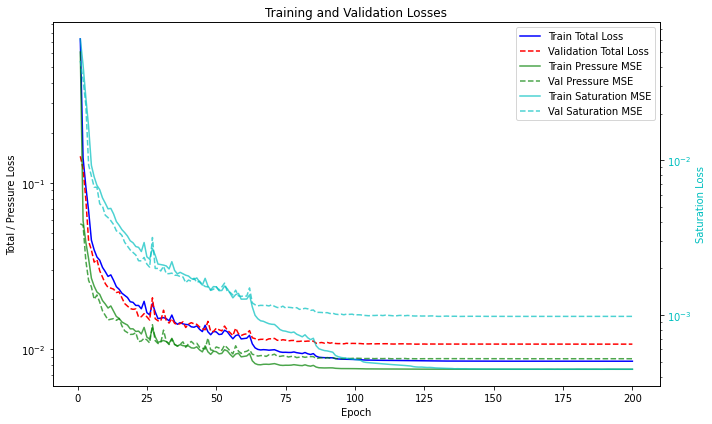

In [33]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total / Pressure Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
ax2 = ax1.twinx()
ax2.plot(epochs, train_s_hist, 'c-', alpha=0.7, label='Train Saturation MSE')
ax2.plot(epochs, val_s_hist, 'c--', alpha=0.7, label='Val Saturation MSE')
ax2.set_ylabel("Saturation Loss", color='c')
ax2.tick_params(axis='y', labelcolor='c')


# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.yscale('log')

plt.title("Training and Validation Losses")
plt.tight_layout()
plt.show()

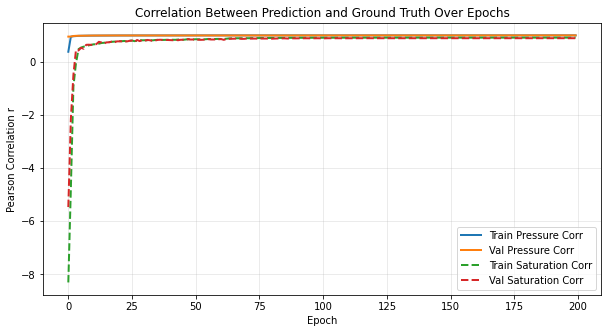

In [34]:
plt.figure(figsize=(10,5))
plt.plot(train_p_corr_hist, label="Train Pressure Corr", linewidth=2)
plt.plot(val_p_corr_hist, label="Val Pressure Corr", linewidth=2)
plt.plot(train_s_corr_hist, label="Train Saturation Corr", linestyle="--", linewidth=2)
plt.plot(val_s_corr_hist, label="Val Saturation Corr", linestyle="--", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Pearson Correlation r")
plt.title("Correlation Between Prediction and Ground Truth Over Epochs")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [35]:
model.train()
X_small, Y_small = next(iter(train_loader))  # one batch
X_small, Y_small = X_small.to(device), Y_small.to(device)

opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay= 1e-4)  # higher lr, no wd

for i in range(50):
    opt.zero_grad()
    pred = model(X_small)
    loss, lp, ls = loss_fn(pred, Y_small, lambda_s=2.0)
    loss.backward()
    opt.step()
    if (i+1) % 5 == 0:
        print(f"iter {i+1:02d}: loss={loss.item():.4f}  Lp={lp:.4f}  Ls={ls:.4f}")


iter 05: loss=0.0196  Lp=0.0147  Ls=0.0024
iter 10: loss=0.0096  Lp=0.0058  Ls=0.0019
iter 15: loss=0.0060  Lp=0.0026  Ls=0.0017
iter 20: loss=0.0042  Lp=0.0021  Ls=0.0010
iter 25: loss=0.0031  Lp=0.0015  Ls=0.0008
iter 30: loss=0.0024  Lp=0.0010  Ls=0.0007
iter 35: loss=0.0020  Lp=0.0008  Ls=0.0006
iter 40: loss=0.0018  Lp=0.0008  Ls=0.0005
iter 45: loss=0.0014  Lp=0.0006  Ls=0.0004
iter 50: loss=0.0013  Lp=0.0005  Ls=0.0004


In [36]:
optimizer.zero_grad()
pred = model(X_small)
loss, _, _ = loss_fn(pred, Y_small)
loss.backward()

total_norm = 0.0
nz_params = 0
for p in model.parameters():
    if p.grad is not None:
        g = p.grad.data
        total_norm += (g.norm(2).item())**2
        nz_params += int(g.abs().sum().item() > 0)
print(f"grad_norm={total_norm**0.5:.2e}, nz_grad_params={nz_params}")

grad_norm=2.91e-02, nz_grad_params=148


In [37]:
# One sample from dataset, BEFORE batching
X, Y = train_dataset[0]
P_in, S_in = X[0].numpy(), X[1].numpy()
P_tgt, S_tgt = Y[0].numpy(), Y[1].numpy()
print("P_in mean/std:", P_in.mean(), P_in.std())
print("P_tgt mean/std:", P_tgt.mean(), P_tgt.std())
print("S_in range:", S_in.min(), S_in.max())
print("S_tgt range:", S_tgt.min(), S_tgt.max())


P_in mean/std: 0.19534595 0.96222216
P_tgt mean/std: 0.31858677 1.0651975
S_in range: 0.0 0.0
S_tgt range: 0.0 0.44979122


In [38]:
# on a random batch
Xb, Yb = next(iter(train_loader))
S_true = Yb[:,1]  # (B,35,35,11)

print("S_true stats:",
      "mean=", S_true.mean().item(),
      "max=",  S_true.max().item())

frac_plume = (S_true > 0.02).float().mean().item()
print("Fraction of cells with S > 0.02:", frac_plume)


S_true stats: mean= 0.008488060906529427 max= 0.6286923289299011
Fraction of cells with S > 0.02: 0.04242671653628349


## Loss Visualization

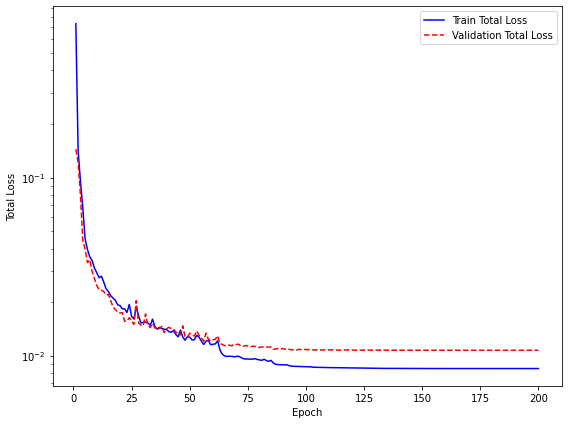

In [39]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
# ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
# ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
#ax2 = ax1.twinx()
#ax2.plot(epochs, train_s_hist, 'c-', alpha=0.7, label='Train Saturation MSE')
#ax2.plot(epochs, val_s_hist, 'c--', alpha=0.7, label='Val Saturation MSE')
#ax2.set_ylabel("Saturation Loss", color='c')
#ax2.tick_params(axis='y', labelcolor='c')
#plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 , labels_1 , loc='upper right')


# plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('train_val loss.png', dpi=600)
plt.show()

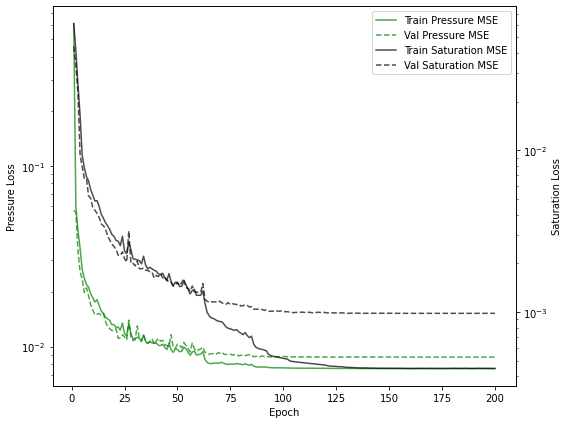

In [40]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
#ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
#ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.plot(epochs, train_p_hist, 'g-', alpha=0.7, label='Train Pressure MSE')
ax1.plot(epochs, val_p_hist, 'g--', alpha=0.7, label='Val Pressure MSE')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Pressure Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Secondary y-axis: saturation losses ---
ax2 = ax1.twinx()
ax2.plot(epochs, train_s_hist, 'k-', alpha=0.7, label='Train Saturation MSE')
ax2.plot(epochs, val_s_hist, 'k--', alpha=0.7, label='Val Saturation MSE')
ax2.set_ylabel("Saturation Loss", color='k')
ax2.tick_params(axis='y', labelcolor='k')
plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')


#plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('press sat train_val loss.png', dpi=600)
plt.show()

## Test Set Evaluation

In [41]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
#test_loader = dev_loader 

In [42]:
start_time = time.time()
model.eval()
preds_P, preds_S = [], []
truth_P, truth_S = [], []

with torch.no_grad():
    for X, Y in tqdm(test_loader, desc="Evaluating on test set"):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        P_pred, S_pred = pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy()
        P_true, S_true = Y[:, 0].cpu().numpy(), Y[:, 1].cpu().numpy()

        preds_P.append(P_pred)
        preds_S.append(S_pred)
        truth_P.append(P_true)
        truth_S.append(S_true)

end_time = time.time()
test_time = end_time - start_time
print("Test time: %.4f" %(test_time))
# concatenate along batch dimension
preds_P = np.concatenate(preds_P, axis=0)
preds_S = np.concatenate(preds_S, axis=0)
truth_P = np.concatenate(truth_P, axis=0)
truth_S = np.concatenate(truth_S, axis=0)


Evaluating on test set: 100%|██████████| 100/100 [00:01<00:00, 71.94it/s]


Test time: 1.3930


## Post processing
### Feel free to ignore anything beneath this

In [43]:
# flatten everything (B, X, Y, Z) → 1D
p_pred_flat = preds_P.flatten()
p_true_flat = truth_P.flatten()
s_pred_flat = preds_S.flatten()
s_true_flat = truth_S.flatten()

metrics = {}

for name, pred, true in [
    ("Pressure", p_pred_flat, p_true_flat),
    ("Saturation", s_pred_flat, s_true_flat),
]:
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    metrics[name] = dict(RMSE=rmse, MAE=mae, R2=r2)

metrics

{'Pressure': {'RMSE': 0.1104227612795739,
  'MAE': 0.04343945160508156,
  'R2': 0.9878454804420471},
 'Saturation': {'RMSE': 0.011229608984876478,
  'MAE': 0.005611889995634556,
  'R2': 0.9490376710891724}}

In [44]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)

print(f"Pressure Abs Error P10/P50/P90: {p_P}")
print(f"Saturation Abs Error P10/P50/P90: {p_S}")

Pressure Abs Error P10/P50/P90: [0.00173175 0.01007146 0.12089362]
Saturation Abs Error P10/P50/P90: [0.00213232 0.00335848 0.00999815]


/tmp/ipykernel_38148/478076837.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


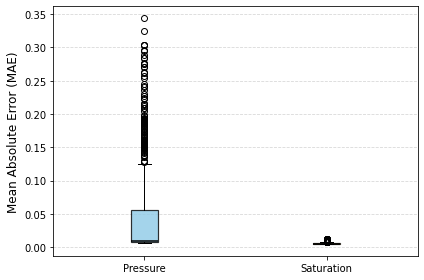

In [45]:
abs_err_P = np.abs(p_pred_flat - p_true_flat)
abs_err_S = np.abs(s_pred_flat - s_true_flat)

percentiles = [10, 50, 90]
p_P = np.percentile(abs_err_P, percentiles)
p_S = np.percentile(abs_err_S, percentiles)


# preds_P, truth_P: shape (N, 35, 35, 11)
# preds_S, truth_S: shape (N, 35, 35, 11)

N = preds_P.shape[0]

mae_P = []
mae_S = []

for i in range(N):
    p_pred = preds_P[i]
    p_true = truth_P[i]
    s_pred = preds_S[i]
    s_true = truth_S[i]

    mae_P.append(np.mean(np.abs(p_pred - p_true)))
    mae_S.append(np.mean(np.abs(s_pred - s_true)))

mae_P = np.array(mae_P)
mae_S = np.array(mae_S)

plt.figure(figsize=(6,4))

data = [mae_P, mae_S]
labels = ["Pressure", "Saturation"]
colors = ['#8ecae6', '#ffb703']

bp = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black'),
    boxprops=dict(linewidth=1.2, color='black')
)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set(facecolor=color, alpha=0.8)

plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

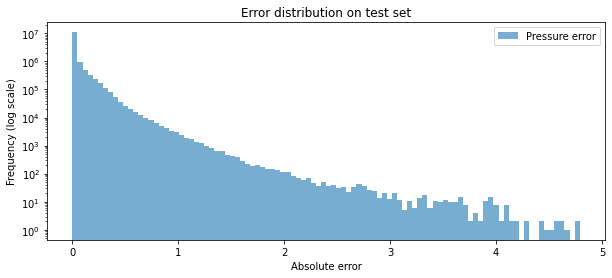

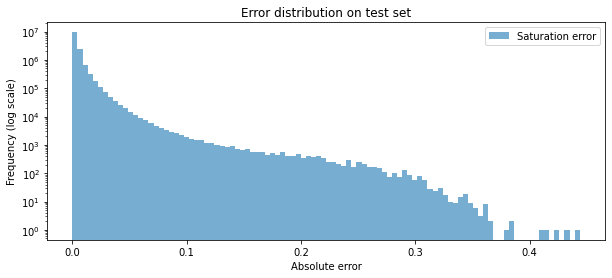

In [46]:
plt.figure(figsize=(10,4))
plt.hist(abs_err_P, bins=100, alpha=0.6, label="Pressure error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(abs_err_S, bins=100, alpha=0.6, label="Saturation error")
plt.yscale('log')
plt.xlabel("Absolute error")
plt.ylabel("Frequency (log scale)")
plt.legend()
plt.title("Error distribution on test set")
plt.show()

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


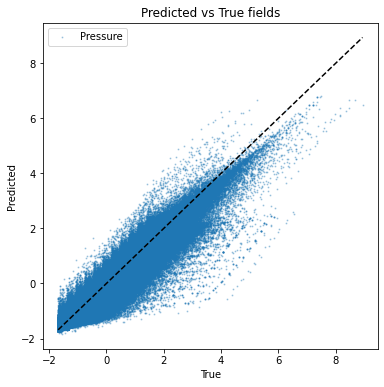

In [47]:
plt.figure(figsize=(6,6))
plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
#plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([p_true_flat.min(), p_true_flat.max()],
         [p_true_flat.min(), p_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()


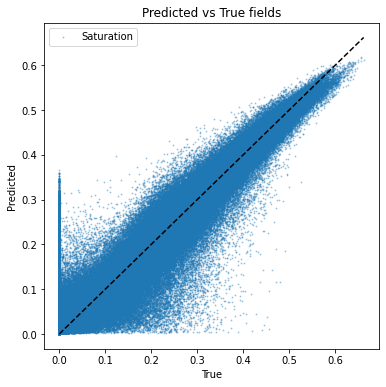

In [48]:
plt.figure(figsize=(6,6))
#plt.scatter(p_true_flat, p_pred_flat, s=1, alpha=0.3, label="Pressure")
plt.scatter(s_true_flat, s_pred_flat, s=1, alpha=0.3, label="Saturation")
plt.plot([s_true_flat.min(), s_true_flat.max()],
         [s_true_flat.min(), s_true_flat.max()],
         'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Predicted vs True fields")
plt.show()

In [49]:
# 3D plotting helper function
def plotter3D(vars_3d, title):
    nx, ny, nz = vars_3d.shape
    #norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))
    x, y, z = np.indices((nx + 1, ny + 1, nz + 1))
    
    plt.rc('font', size=12)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    # ax.set_box_aspect((1, 1, 1))
    #ax.invert_zaxis()
    ax.invert_yaxis()
    # ax.invert_xaxis()
    
    ax.set_axis_off()
    
    # Add axis direction labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Hide ticks and grid lines, but keep labels
    ax.grid(False)  # Disable grid lines
    
    ax.view_init(elev=30, azim=0)  # 60, -60
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 1, 1]))
    # plotting black boundary box
    ax.plot3D([0, nx], [0, 0], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [0, 0], [nz, nz], 'k', linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, nx], [ny, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([nx, nx], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    ax.plot3D([0, 0], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.5)
    
    
    colors = plt.cm.jet(norm(vars_3d.transpose((0, 1, 2))))
    filled = np.where(vars_3d.transpose((0, 1, 2)) > 0, np.ones((nx, ny, nz)), np.zeros((nx, ny, nz)))
    
    vox = ax.voxels(x, y, z, filled, facecolors=colors,
                    edgecolors=colors,  # brighter
                    linewidth=0.5,
                    alpha=1, shade=False)
    
    
    m = cm.ScalarMappable(cmap=cm.jet, norm=norm)
    m.set_array([])
    plt.colorbar(m, ax=ax, shrink=0.5, pad=0.001)
    plt.title(title)
    plt.tight_layout()
    # plt.savefig(title+'.png', dpi=600)
    plt.show()

In [50]:
preds_P.shape, truth_P.shape, preds_S.shape, truth_S.shape

((1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11),
 (1000, 35, 35, 11))

In [51]:
example = 5

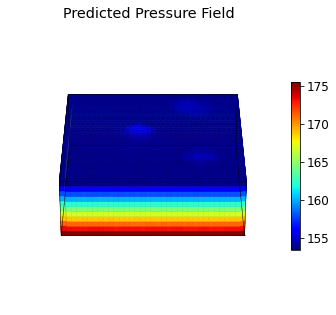

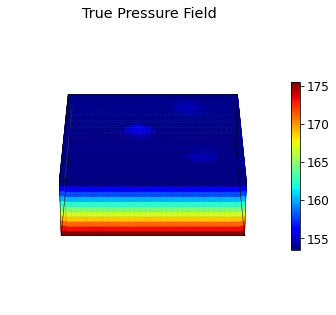

In [52]:
res_p_p = ((preds_P[example] * P_SIGMA) + P_MU) / 1e5
res_p_t = ((truth_P[example] * P_SIGMA) + P_MU) / 1e5
plotter3D(res_p_p, 'Predicted Pressure Field')
plotter3D(res_p_t, 'True Pressure Field')

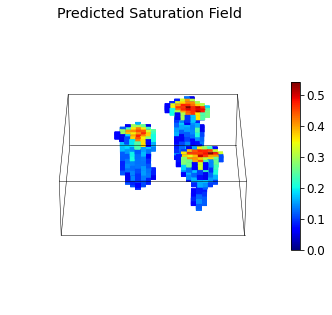

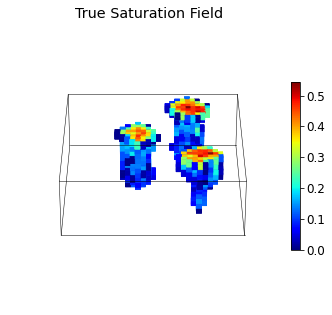

In [53]:
res_s_p = preds_S[example].copy()     # (35, 35, 11)
res_s_p[res_s_p < 0.05] = 0.0         # zero out small saturations
res_s_t = truth_S[example]
plotter3D(res_s_p, 'Predicted Saturation Field')
plotter3D(res_s_t, 'True Saturation Field')

In [54]:
def rollout_one_run(model, dataset, run_number, device):
    """
    Autoregressive rollout on a single GEOS run in test_dataset.

    run_number: integer 0 .. (num_runs-1)
    """
    model.eval()
    Nt = dataset.Nt          # 11
    steps = Nt - 1           # 10

    # compute the correct dataset index range
    base_idx = run_number * steps

    preds = []
    trues = []

    with torch.no_grad():

        # --- first step: use dataset's true initial state ---
        X_k, Y_true = dataset[base_idx]   # guaranteed to be the first transition of this run
        X_k = X_k.clone()

        X_t = X_k.unsqueeze(0).to(device)
        Y_true_t = Y_true.unsqueeze(0).to(device)

        Y_pred_t = model(X_t)

        preds.append(Y_pred_t.squeeze(0).cpu().numpy())
        trues.append(Y_true_t.squeeze(0).cpu().numpy())

        # next input state = predicted output
        P_next = Y_pred_t[0,0].cpu()
        S_next = Y_pred_t[0,1].cpu()

        # --- subsequent 9 steps ---
        for k in range(1, steps):
            idx = base_idx + k

            X_k, Y_true = dataset[idx]
            X_k = X_k.clone()

            # replace channels 0 and 1 with predicted P,S
            X_k[0] = P_next
            X_k[1] = S_next

            X_t = X_k.unsqueeze(0).to(device)
            Y_true_t = Y_true.unsqueeze(0).to(device)

            Y_pred_t = model(X_t)

            preds.append(Y_pred_t.squeeze(0).cpu().numpy())
            trues.append(Y_true_t.squeeze(0).cpu().numpy())

            P_next = Y_pred_t[0,0].cpu()
            S_next = Y_pred_t[0,1].cpu()

    preds = np.stack(preds)
    trues = np.stack(trues)
    return preds, trues


In [55]:
def plotter3D_sub(ax, vars_3d, title=""):
    nx, ny, nz = vars_3d.shape
    norm = matplotlib.colors.Normalize(vmin=np.min(vars_3d), vmax=np.max(vars_3d))

    x, y, z = np.indices((nx + 1, ny + 1, nz + 1))
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    ax.invert_yaxis()
    ax.set_axis_off()

    # boundary box
    ax.plot3D([0, nx], [0, 0], [0, 0], 'k',  linewidth=0.3)
    ax.plot3D([0, nx], [0, 0], [nz, nz], 'k', linewidth=0.3)
    ax.plot3D([0, nx], [ny, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, nx], [ny, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, ny], [0, 0], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, ny], [nz, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([nx, nx], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [0, 0], [0, nz], 'k', zorder=1e6, linewidth=0.3)
    ax.plot3D([0, 0], [ny, ny], [0, nz], 'k', zorder=1e6, linewidth=0.3)

    colors = plt.cm.jet(norm(vars_3d))
    filled = vars_3d > 0.0

    ax.voxels(
        x, y, z,
        filled,
        facecolors=colors,
        edgecolors=colors,
        linewidth=0.05,
        alpha=1.0,
        shade=False
    )

    ax.set_title(title, fontsize=10)


def compare_rollout_8panel(pred_seq, true_seq, timesteps, savefig=None):
    fig = plt.figure(figsize=(14, 7))

    for j, k in enumerate(timesteps):
        # predicted saturation
        ax = fig.add_subplot(2, 4, j+1, projection='3d')
        sat_pred = pred_seq[k, 1].copy()
        sat_pred[sat_pred < 0.05] = 0.0
        plotter3D_sub(ax, sat_pred, title=f"Pred t={5*(k+1)}y")

        # true saturation
        ax = fig.add_subplot(2, 4, j+5, projection='3d')
        sat_true = true_seq[k, 1].copy()
        sat_true[sat_true < 0.05] = 0.0
        plotter3D_sub(ax, sat_true, title=f"True t={5*(k+1)}y")

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=600)
    plt.show()

In [ ]:
timesteps_to_plot = [0, 3, 6, 9]
run_number = 19     # example run
pred_seq, true_seq = rollout_one_run(model, test_dataset, run_number, device)

compare_rollout_8panel(pred_seq, true_seq, timesteps_to_plot,
                       savefig="rollout_comparison_run3.png")


## For Considerations

In [ ]:
def compute_ssim_3d_batch(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    data_range: float = None,
    slice_axis: int = 2,
):
    """
    Compute SSIM between predicted and true 3D fields (pressure/saturation).

    Args:
        y_true: torch.Tensor with shape (B, C, D, H, W) or (B, D, H, W)
        y_pred: torch.Tensor with same shape as y_true
        data_range: dynamic range of the data. If None, inferred from y_true.
        slice_axis: axis index for 'depth' if you want to slice along
                    a different dimension (default assumes (B, C, D, H, W)).

    Returns:
        mean_ssim: scalar float, average SSIM over batch
        ssim_per_sample: list of per-sample SSIM values
    """
    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"

    # Move to CPU + numpy
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # Handle (B, D, H, W) → (B, 1, D, H, W)
    if y_true_np.ndim == 4:
        y_true_np = y_true_np[:, None, ...]
        y_pred_np = y_pred_np[:, None, ...]

    # Now assume shape (B, C, D, H, W)
    assert y_true_np.ndim == 5, "Expected 5D tensor (B, C, D, H, W)"

    B, C, D, H, W = y_true_np.shape

    if data_range is None:
        data_range = float(y_true_np.max() - y_true_np.min() + 1e-8)

    ssim_per_sample = []

    # Iterate over batch
    for b in range(B):
        ssim_channels = []

        # Iterate over channels
        for c in range(C):
            # Extract 3D volumes for this sample + channel
            vol_true = y_true_np[b, c]   # (D, H, W)
            vol_pred = y_pred_np[b, c]   # (D, H, W)

            # Compute SSIM slice-wise along depth (axis 0 of vol_true)
            ssim_slices = []
            for d in range(D):
                gt_slice = vol_true[d, :, :]   # (H, W)
                pr_slice = vol_pred[d, :, :]   # (H, W)

                s = ssim(
                    gt_slice,
                    pr_slice,
                    data_range=data_range,
                    gaussian_weights=True,
                    use_sample_covariance=False,
                )
                ssim_slices.append(s)

            # Average over slices for this channel
            ssim_channels.append(float(np.mean(ssim_slices)))

        # Average over channels for this sample
        ssim_per_sample.append(float(np.mean(ssim_channels)))

    mean_ssim = float(np.mean(ssim_per_sample))
    return mean_ssim, ssim_per_sample


# Example usage
if __name__ == "__main__":
    # Fake example: batch of 3D pressure volumes
    B, C, D, H, W = 2, 1, 11, 35, 35
    y_true = torch.rand(B, C, D, H, W)
    y_pred = y_true + 0.05 * torch.randn(B, C, D, H, W)

    mean_ssim, per_sample = compute_ssim_3d_batch(y_true, y_pred)
    print("Mean SSIM (3D):", mean_ssim)
    print("Per-sample SSIM:", per_sample)